
# Objectives
Ball, Goalpost, and robot detector.
Implement one of the three suggested models (SweatyNet-1 or SweatyNet-2 or SweatyNet-3)

# change log 18-02-2018
- values of labels are amplified by 100
- learning rate 0.001, tried 0.005/0.0015 higher rate appeared to cause more noise in the raw output
- batch size 8 
- changed sigma of the normal distribution for heatmaps 4-> 6
- changed dropout rate 0.3->0.5->0.4->0.3    (seems no effect)
- threshold was set to 60% instead of 70% of all maximum of all training data


In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.transforms import RandomCrop, RandomHorizontalFlip 

import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import join,isfile
import time
import numpy as np
import math
import random
import scipy.ndimage
from sklearn.metrics import euclidean_distances

from bs4 import BeautifulSoup
import copy
import lxml
from lxml import etree

# Use RandomCrop instead of RandomResizeCrop: bcz for some reason RandomResizeCrop cannot generate non-squared images

import lxml
from lxml import etree
from PIL import Image

np.random.seed(1)
torch.manual_seed(1)

### Parse the label text files (from imagetagger.bit-bots.de), append to all_labels.xml

In [4]:
def parse_label_file(label_filename): # final version, simplified
    """
    A generator, each iteration returns a tuple:
    (image_name, image_width, image_height, 
    [(ball_1_xmin, ball_1_ymin, ball_1_xmax, ball_1_ymax),(),...], 
    [(robot_1_xmin, robot_1_ymin, robot_1_xmax, robot_1_ymax),(),...], 
    [(goalpost_1_xmin, goalpost_1_ymin, goalpost_1_xmax, goalpost_1_ymax),(),...])
    """
    with open(label_filename,'r') as label_file:
        line=label_file.readline() # read one line
        while "name" not in line: # Read until reaches image name
            if not line: # if has reached the end of file 
                print("End of file")
                return
            line=label_file.readline() # read next line

        while True: # each iteration parses information of one image
            # information of object coordinates are stored in the lists
            ball_coordinate_list=[]
            robot_coordinate_list=[]
            goalpost_coordinate_list=[]
            
            # Now the line contains "name"
            image_name=line.split()[-1]

            line=label_file.readline() # Read the next line, it should be width
            if "width" in line:
                image_width=line.split()[-1]
            else: # In case width is not found in the next line following image name
                print('Error in line: cannot find width in the next line following image name')
                print(line)
                return

            line=label_file.readline() # Read the next line, it should be height
            if "height" in line:
                image_height=line.split()[-1]
            else: # In case width is not found in the next line following image name
                print('Error in line: cannot find height in the next line following image width')
                print(line)
                return

            # To find labels of objects                
            while "name" not in line: # Read until reaches image name
                if not line: # if has reached the end of file 
                    print("End of file")
                    return
                line=label_file.readline() # read next line         
                if "type" in line: # Start of one labeled object
                    obj_type=line.split()[-1] # type of object: "ball", "robot", "goalpost"
                    if obj_type=="ball" or obj_type=="robot" or obj_type=="goalpost": # ignore other types of objects, such as goal
                        line=label_file.readline() # verification

                        """Careful!! The x and y of the YAML label format is reversed from the actual label (x,y)!!"""
                        line=label_file.readline() # actual y
                        y=line.split()[-1]

                        line=label_file.readline() # actual x
                        x=line.split()[-1]

                        line=label_file.readline() # dia

                        line=label_file.readline() # width
                        width=line.split()[-1]

                        line=label_file.readline() # height
                        height=line.split()[-1]
                        
                        if x=='-1': # Object doesn't exist
                            xmin='-1'
                            ymin='-1'
                            xmax='-1'
                            ymax='-1'
                        else: 
                            xmin=str(int(float(x)-float(width)/2))
                            ymin=str(int(float(y)-float(height)/2))
                            xmax=str(int(float(x)+float(width)/2))
                            ymax=str(int(float(y)+float(height)/2))

                        if obj_type=="ball":
                            ball_coordinate_list.append((xmin,ymin,xmax,ymax))
                        elif obj_type=="robot":
                            robot_coordinate_list.append((xmin,ymin,xmax,ymax))
                        else: 
                            goalpost_coordinate_list.append((xmin,ymin,xmax,ymax))                            

            # check if all 3 types of objects are labeled:
            if len(ball_coordinate_list)*len(robot_coordinate_list)*len(goalpost_coordinate_list)!=0:
                yield (image_name, image_width, image_height, ball_coordinate_list, robot_coordinate_list, goalpost_coordinate_list)
        
def img_label_to_xml(label_filename, xml_filename): # xml_filename is the destination to write the information
    """Write the output from parse_label_file() to xml file"""
    
    with open("label_template.xml",'r') as template_xml:
        soup=BeautifulSoup(template_xml.read(),'xml') # template of the label of one image
        
        with open(xml_filename,'a') as xml_file:            
            # For each image
            for (image_name, image_width, image_height, ball_list, robot_list, goalpost_list) in parse_label_file(label_filename):
                num_obj=len(ball_list)+len(robot_list)+len(goalpost_list)
                num_obj_temp=len(soup.find_all('object')) # number of object templates
                if num_obj>=num_obj_temp: 
                    # make sure there is the number of object templates equals the number of objects in this image
                    for _ in range(num_obj - num_obj_temp):
                        soup.image.insert(-1,copy.copy(soup.object)) # insert more obj templates in the end of xml tree
                else: 
                    for _ in range(num_obj_temp - num_obj):
                        soup.object.extract() # remove excessive obj templates
                        
                
                soup.filename.string=image_name # change the file name to image name
                size_soup=soup.size
                size_soup.find('width').string=image_width
                size_soup.find('height').string=image_height
                
                # Set the labeled coordinates
                obj_idx=0 # object index
                for (xmin,ymin,xmax,ymax) in ball_list: # for all ball objects
                    obj_template_list=soup.find_all('object')
                    curr_obj=obj_template_list[obj_idx] # current object
                    curr_obj.find('name').string='ball' # cannot use curr_obj.name! it just returns the name as a string
                    bndbox_obj=curr_obj.bndbox
                    bndbox_obj.xmin.string=xmin # change the labels accordingly
                    bndbox_obj.ymin.string=ymin
                    bndbox_obj.xmax.string=xmax
                    bndbox_obj.ymax.string=ymax
                    obj_idx+=1
                for (xmin,ymin,xmax,ymax) in robot_list: # for all robot objects
                    obj_template_list=soup.find_all('object')
                    curr_obj=obj_template_list[obj_idx] # current object
                    curr_obj.find('name').string='robot'
                    bndbox_obj=curr_obj.bndbox
                    bndbox_obj.xmin.string=xmin # change the labels accordingly
                    bndbox_obj.ymin.string=ymin
                    bndbox_obj.xmax.string=xmax
                    bndbox_obj.ymax.string=ymax
                    obj_idx+=1
                for (xmin,ymin,xmax,ymax) in goalpost_list: # for all ball objects
                    obj_template_list=soup.find_all('object')
                    curr_obj=obj_template_list[obj_idx] # current object
                    curr_obj.find('name').string='goalpost'
                    bndbox_obj=curr_obj.bndbox
                    bndbox_obj.xmin.string=xmin # change the labels accordingly
                    bndbox_obj.ymin.string=ymin
                    bndbox_obj.xmax.string=xmax
                    bndbox_obj.ymax.string=ymax
                    obj_idx+=1
                xml_file.write(soup.image.prettify()+'\n\n')


"""Generate the xml file for all images:"""
# for filename in os.listdir('./labels'): 
#     if filename.endswith('txt'):
#         img_label_to_xml('./labels/'+filename, "test_all_labels.xml")


'Generate the xml file for all images:'

### Parse xml (from train_cnn), append to all_labels.xml

In [5]:
def get_label_from_xml(xml_filename):
    """Get label lists from xml files, each file contains only label info of a single image!"""
    
    ball_coordinate_list=[]
    robot_coordinate_list=[]
    goalpost_coordinate_list=[]
    
    tree = etree.parse(xml_filename)  # parse directly from a file
    root = tree.getroot() # root Element
    
    image_name = root.xpath('filename')[0].text+'.jpg' # search for tag 'filename' in the whole tree
    image_width = root.xpath('size/width')[0].text
    image_height = root.xpath('size/height')[0].text
    obj_list = tree.xpath('object')
    
    for obj in obj_list:
        xmin = obj.xpath('bndbox/xmin')[0].text
        ymin = obj.xpath('bndbox/ymin')[0].text
        xmax = obj.xpath('bndbox/xmax')[0].text
        ymax = obj.xpath('bndbox/ymax')[0].text
        if obj.xpath('name')[0].text=="ball":
            ball_coordinate_list.append((xmin, ymin, xmax, ymax))
        elif obj.xpath('name')[0].text=="robot":
            robot_coordinate_list.append((xmin, ymin, xmax, ymax))
        elif obj.xpath('name')[0].text=="goalpost":
            goalpost_coordinate_list.append((xmin, ymin, xmax, ymax))
    if len(ball_coordinate_list)==0: # if no ball is found in the image
        ball_coordinate_list.append(('-1','-1','-1','-1'))
    if len(robot_coordinate_list)==0: # if no robot is found in the image
        robot_coordinate_list.append(('-1','-1','-1','-1'))
    if len(goalpost_coordinate_list)==0: # if no goalpost is found in the image
        goalpost_coordinate_list.append(('-1','-1','-1','-1'))
    
    return (image_name, image_width, image_height, ball_coordinate_list, robot_coordinate_list, goalpost_coordinate_list)

    
def img_label_to_xml_2(label_filename, xml_filename): # xml_filename is the destination to write the information
    """Write the output from get_label_from_xml() to xml file"""
    
    with open("label_template.xml",'r') as template_xml:
        soup=BeautifulSoup(template_xml.read(),'xml') # template of the label of one image
        
        with open(xml_filename,'a') as xml_file:            
            # For each image
            (image_name, image_width, image_height, ball_list, robot_list, goalpost_list) = get_label_from_xml(label_filename)
            num_obj=len(ball_list)+len(robot_list)+len(goalpost_list)
            num_obj_temp=len(soup.find_all('object')) # number of object templates
            if num_obj>=num_obj_temp: 
                # make sure there is the number of object templates equals the number of objects in this image
                for _ in range(num_obj - num_obj_temp):
                    soup.image.insert(-1,copy.copy(soup.object)) # insert more obj templates in the end of xml tree
            else: 
                for _ in range(num_obj_temp - num_obj):
                    soup.object.extract() # remove excessive obj templates


            soup.filename.string=image_name # change the file name to image name
            size_soup=soup.size
            size_soup.find('width').string=image_width
            size_soup.find('height').string=image_height

            # Set the labeled coordinates
            obj_idx=0 # object index
            for (xmin,ymin,xmax,ymax) in ball_list: # for all ball objects
                obj_template_list=soup.find_all('object')
                curr_obj=obj_template_list[obj_idx] # current object
                curr_obj.find('name').string='ball' # cannot use curr_obj.name! it just returns the name as a string
                bndbox_obj=curr_obj.bndbox
                bndbox_obj.xmin.string=xmin # change the labels accordingly
                bndbox_obj.ymin.string=ymin
                bndbox_obj.xmax.string=xmax
                bndbox_obj.ymax.string=ymax
                obj_idx+=1
            for (xmin,ymin,xmax,ymax) in robot_list: # for all robot objects
                obj_template_list=soup.find_all('object')
                curr_obj=obj_template_list[obj_idx] # current object
                curr_obj.find('name').string='robot'
                bndbox_obj=curr_obj.bndbox
                bndbox_obj.xmin.string=xmin # change the labels accordingly
                bndbox_obj.ymin.string=ymin
                bndbox_obj.xmax.string=xmax
                bndbox_obj.ymax.string=ymax
                obj_idx+=1
            for (xmin,ymin,xmax,ymax) in goalpost_list: # for all ball objects
                obj_template_list=soup.find_all('object')
                curr_obj=obj_template_list[obj_idx] # current object
                curr_obj.find('name').string='goalpost'
                bndbox_obj=curr_obj.bndbox
                bndbox_obj.xmin.string=xmin # change the labels accordingly
                bndbox_obj.ymin.string=ymin
                bndbox_obj.xmax.string=xmax
                bndbox_obj.ymax.string=ymax
                obj_idx+=1
            xml_file.write(soup.image.prettify()+'\n\n')
                
"""Generate the xml file for all single image xml files in train_cnn:"""
# for filename in os.listdir('./train_cnn'): 
#     if filename.endswith('xml'):
#         img_label_to_xml_2('./train_cnn/'+filename, "test_all_labels.xml")

'Generate the xml file for all single image xml files in train_cnn:'

### Heatmap generation

In [6]:
def gaussian_pdf(x, y, mu_x, mu_y, sigma):
    """this 2d gaussian function assumes identical standard deviation, and independence between the 2 dimensions"""
    var = sigma ** 2
    c1 = 1.0 / (2 * math.pi * var)
    return c1 * np.exp(-1.0 * ((x - mu_x) ** 2 + (y - mu_y) ** 2) / (2.0 * var))


def generate_heatmap(coordinates, sigma, img_size, centroid=True):  # img_size=(height, width)
    """this function takes in 1 list containing coordinates of of bounding boxes of all objects of same class (e.g. 2 balls in a image)
    and generate a heatmap containing normal distributions around the middle point of all objects"""
    grid = np.zeros(img_size)  # fixed for now
    for tuple in coordinates:
        x_min, y_min, x_max, y_max = tuple  # unpack the tuple
        if x_min<0: # which means object does not exist in image
            return grid
        if centroid:
            h, k= x_min+abs(x_max - x_min) / 2,  y_min+abs(y_max - y_min) / 2  # centroid coordinate
        else:
            h, k = x_min+abs(x_max - x_min) / 2, y_max # for goalpost we want to detect the bottom of it
        
        rr = np.arange(grid.shape[0])
        cc = np.arange(grid.shape[1])
        individual_item = gaussian_pdf(rr[:, None], cc[None, :], k, h, sigma) # 'numpy.newaxis' is an alias of None
        grid += individual_item
    return grid


def generate_heatmap_label(ball,goalpost,robot,sigma, img_size=(600,800)): # img_size=(height,width)
    """this function takes 3 lists containing the coordinates of ball, goalpost and robot.
    Output: 3 heatmaps stacked as numpy array(n,m,3) """
    arrays=[]
    grid_ball=generate_heatmap(ball,sigma, img_size)
    if grid_ball.max(axis=(0,1))>0: # no need to normalize if all elements are 0
        grid_ball = grid_ball/grid_ball.max(axis=(0,1)) # Normalize to [0,1]
    arrays.append(grid_ball)
    
    grid_goalpost=generate_heatmap(goalpost,sigma, img_size, centroid=True)
    if grid_goalpost.max(axis=(0,1))>0: # no need to normalize if all elements are 0
        grid_goalpost = grid_goalpost/grid_goalpost.max(axis=(0,1)) # Normalize to [0,1]
    arrays.append(grid_goalpost)
    
    grid_robot=generate_heatmap(robot,sigma, img_size, centroid=True)
    if grid_robot.max(axis=(0,1))>0: # no need to normalize if all elements are 0
        grid_robot = grid_robot/grid_robot.max(axis=(0,1)) # Normalize to [0,1]
    arrays.append(grid_robot)
    result=np.stack(arrays, axis=2)

    return result

### Define class SoccerDataset
- Generate the probability heatmap (target) from the labels, and apply the same transformation on the target as well as the image
  - Reference: https://github.com/pytorch/vision/issues/9

- Method of implementation:
Inherit the transformation class and make it able to transform more than 1 image with the same random parameters

If user set 'random_img' to True, do the following:
  1. Random crop according to expected aspect ratio (to image and target heatmap at the same time)
  2. RandomHorizontalFlip (to image and target heatmap at the same time)
  3. ColorJitter: randomly changing brightness (to image alone)
  4. Resize to expected output size (to image and target heatmap separately)
  5. ToTensor (to image and target heatmap separately)


In [7]:
"""
Inherit the transformation classes and make it able to transform more than 1 image at one time
1. PairedRandomCrop from RandomCrop
2. PairedRandomHorizontalFlip from RandomHorizontalFlip
Other transformations: ColorJitter, Resize, ToTensor do not need this kind of modification
"""
class PairedRandomCrop(RandomCrop):
    def __init__(self, *args, **kwargs):
        super(PairedRandomCrop, self).__init__(*args, **kwargs)
    def __call__(self, images):
        """
        Args:
            images (PIL Image): a pair of Image (tuple: image + target) to be cropped.

        Returns:
            PIL Image: Cropped image.
        """
        i, j, h, w = self.get_params(images[0], self.size)

        return (images[0].crop((j, i, j + w, i + h)),
                images[1].crop((j, i, j + w, i + h)))
    
class PairedRandomHorizontalFlip(RandomHorizontalFlip):
    """Horizontally flip the given PIL Image randomly with a probability of 0.5."""
    def __init__(self, *args, **kwargs):
        super(RandomHorizontalFlip, self).__init__(*args, **kwargs)
    def __call__(self, images):
        """
        Args:
            images (PIL Image): a pair of Image (tuple: image + target) to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < 0.5:
            return (images[0].transpose(Image.FLIP_LEFT_RIGHT),
                    images[1].transpose(Image.FLIP_LEFT_RIGHT))
        return images
    
class SoccerDataset(Dataset): # Adapted from mratsim (GitHub)
    """
    Dataset wrapping images and target labels for object position recognition in soccer game images
    Arguments:
        A xml file path
        Path to image folder
        The expected output size: tuple (height, width)
        Boolean value randomize_img (decides to randomize images or not)
        Normalization: in the form of PIL transforms
    """

    def __init__(self, xml_path, img_path, output_size, randomize_img=False, normalize=None): # output_size=(h_o, w_o)
        
        tree = etree.parse(xml_path) # Parse xml as tree
        self.image_list = tree.xpath('image') # A list of all Elements named 'image' in the xml file
        
        self.img_path = img_path
        
        """Decide whether or not to use transformations to image and its target heatmap"""
        self.randomize_img = randomize_img 
        
        # expected width and height of output image
        self.h_o=output_size[0]
        self.w_o=output_size[1]
        
        self.normalize = normalize # Should be the form of transforms: 
        
    def __getitem__(self, index):
        """Process image and target heatmap, returning a tuple of Tensors (img, target)"""
        img_element = self.image_list[index] # a lxml Element
        img_name = img_element.xpath('filename')[0].text.split()[0] # name already contains extension. '.split()[0]' removes all spacing characters
        img_width = int(img_element.xpath('size/width')[0].text)
        img_height = int(img_element.xpath('size/height')[0].text)

        img = Image.open(self.img_path+'/'+img_name) # PIL Image file ### why os.path.join() does not add '/' in this case?
        img = img.convert('RGB') # For safety, but maybe works the same without the step?
        
        """Get the label coordinates from xml"""
        ball_labels=[]
        robot_labels=[]
        goalpost_labels=[]
        label_list = img_element.xpath('object')
        for label in label_list:
            xmin = float(label.xpath('bndbox/xmin')[0].text)
            ymin = float(label.xpath('bndbox/ymin')[0].text)
            xmax = float(label.xpath('bndbox/xmax')[0].text)
            ymax = float(label.xpath('bndbox/ymax')[0].text)

            obj_type=label.xpath('name')[0].text.split()[0] #.split()[0] to remove all spacing characters
            if obj_type=='ball':
                ball_labels.append((xmin, ymin, xmax, ymax))
            elif obj_type=='robot':
                robot_labels.append((xmin, ymin, xmax, ymax))
            elif obj_type=='goalpost':
                goalpost_labels.append((xmin, ymin, xmax, ymax))

        """Generate target probability heatmap"""
        target = generate_heatmap_label(ball_labels, goalpost_labels, robot_labels, 6, img_size=(img_height,img_width))
        target*=255 # The orginal range of values is [0,1], convert to [0,255]
        target=target.astype(np.int8)
        target=Image.fromarray(target, 'RGB') # Attention! Image.fromarray(img, 'RGB') maps from int8 ([0,255]) to color!

        """Apply randomization on images"""
        if self.randomize_img == True:
            # randomly choosing the size for PairedRandomCrop
            expected_aspect = self.h_o/self.w_o # expected aspect ratio
            if img_height/img_width>=expected_aspect:
                w = int(np.random.uniform(img_width * 2/3, img_width)) # width for PairedRandomCrop. 2/3 is arbitrary (bcz we don't want the image cropped too small)
                h = int(w * expected_aspect) # height for PairedRandomCrop
            else:
                h = int(np.random.uniform(img_height * 2/3, img_height))
                w = int(h / expected_aspect)
            
            # 1. 2. Apply the same random cropping and horizontal flipping on target as the image    
            transforms_paired = transforms.Compose([PairedRandomCrop((h,w)),PairedRandomHorizontalFlip()])
            img, target = transforms_paired((img, target))
            
            """Try to change these to the orginal functions in PIL Image: faster?"""
            # 3. Apply ColorJitter on image only: randomly changing brightness in the range [2/3, 4/3]
            change_brightness = transforms.Compose([transforms.ColorJitter(brightness=1/3)])
            img = change_brightness(img)
            
            # 4. Resize both image and target to expected output size
            resize_img = transforms.Compose([transforms.Resize((self.h_o, self.w_o))])
            resize_target = transforms.Compose([transforms.Resize((self.h_o//4, self.w_o//4))]) 
            # Because the output heatmap from the neural network is only 0.25*0.25 size of the original image
            img = resize_img(img)
            target = resize_target(target)
        else: # only resize
            resize = transforms.Compose([transforms.Resize((self.h_o, self.w_o))])
            img = resize(img)
            target = resize(target)
        
        # 5. Transform PIL Image to tensor
        toTensor = transforms.Compose([transforms.ToTensor()])
        img = toTensor(img) 
        target = toTensor(target) # int8 in range [0,255] will be automatically transformed to float in range [0,1]
        
        if self.normalize is not None: # normalize image only, after transforming to tensor
            img = self.normalize(img)
        return img, target

    def __len__(self):
        return len(self.image_list) # the total number of images in the xml file


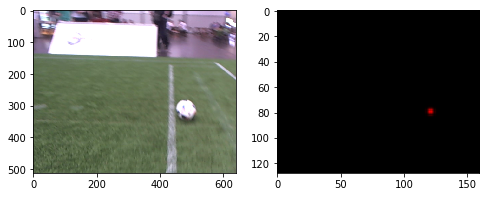

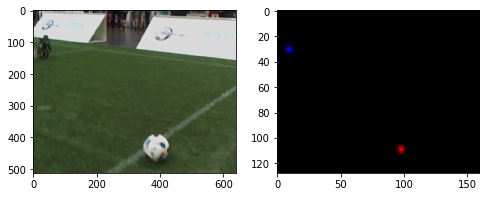

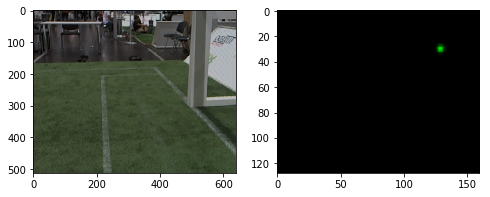

In [8]:
"""Checking if the SoccerDataset works"""
# normalize_data=transforms.Compose([transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25))])
soccor_set = SoccerDataset('./labels_xml/train_labels.xml', './data', (512,640), randomize_img=True, normalize=None)

for i in range(3):
    img, target=soccor_set[i]
    plt.figure(figsize=(8, 6))
    
    ax1=plt.subplot(121)
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    
    ax2=plt.subplot(122)
    target = target.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(target)


## The network SweatyNet-1

In [9]:
class SweatyNet1(nn.Module):
    def __init__(self):
        super(SweatyNet1, self).__init__()
        # Convolution 1
        self.cvn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.cvn1_bn = nn.BatchNorm2d(8)
        # Convolution 2
        self.cvn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.cvn2_bn = nn.BatchNorm2d(16)
        # Convolution 3
        self.cvn3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.cvn3_bn = nn.BatchNorm2d(16)
        # Convolution 4    after depth-concat - 16+8 =24
        self.cvn4 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, padding=1)
        self.cvn4_bn = nn.BatchNorm2d(32)
        # Convolution 5
        self.cvn5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.cvn5_bn = nn.BatchNorm2d(32)
        # Convolution 6   24+32
        self.cvn6 = nn.Conv2d(in_channels=56, out_channels=64, kernel_size=3, padding=1)
        self.cvn6_bn = nn.BatchNorm2d(64)
        # Convolution 7
        self.cvn7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cvn7_bn = nn.BatchNorm2d(64)
        # Convolution 8
        self.cvn8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cvn8_bn = nn.BatchNorm2d(64)
        # Convolution 9  56+64
        self.cvn9 = nn.Conv2d(in_channels=120, out_channels=128, kernel_size=3, padding=1)
        self.cvn9_bn = nn.BatchNorm2d(128)
        # Convolution 10
        self.cvn10 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.cvn10_bn = nn.BatchNorm2d(128)
        # Convolution 11
        self.cvn11 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.cvn11_bn = nn.BatchNorm2d(128)
        # Convolution 12   #
        self.cvn12 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.cvn12_bn = nn.BatchNorm2d(64)
        # Convolution 13
        self.cvn13 = nn.Conv2d(in_channels=184, out_channels=64, kernel_size=1, padding=0)
        self.cvn13_bn = nn.BatchNorm2d(64)
        # Convolution 14
        self.cvn14 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.cvn14_bn = nn.BatchNorm2d(32)
        # Convolution 15
        self.cvn15 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.cvn15_bn = nn.BatchNorm2d(32)
        # Convolution 16
        self.cvn16 = nn.Conv2d(in_channels=88, out_channels=16, kernel_size=1, padding=0)
        self.cvn16_bn = nn.BatchNorm2d(16)
        # Convolution 17
        self.cvn17 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.cvn17_bn = nn.BatchNorm2d(16)
        # Convolution 18
        self.cvn18 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)
        self.cvn18_bn = nn.BatchNorm2d(3)

        self.drop = nn.Dropout(0.3)  # Dropout
        self.upsampling = nn.Upsample(scale_factor=2, mode='bilinear')  # upsampling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pool
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.cvn1_bn(self.cvn1(x)))
        cvn1_pooled_out = self.maxpool(out)  # cvn1 pooled: torch.Size([1, 8, 256, 320])
        out = self.relu(self.cvn2_bn(self.cvn2(cvn1_pooled_out)))  # cvn2: torch.Size([1, 16, 256, 320])
        out = self.relu(self.cvn3_bn(self.cvn3(out)))  # cvn3 torch.Size([1, 16, 256, 320])
        cvn3_out = torch.cat([out, cvn1_pooled_out],
                             dim=1)  # 1st concat layer, assuming it is depth-concat? cvn3 torch.Size([1, 24, 256, 320])
        cvn3_pooled_out = self.maxpool(cvn3_out)  # ([1, 24, 128, 160])
        out = self.relu(self.cvn4_bn(self.cvn4(cvn3_pooled_out)))
        cvn5_out = self.relu(self.cvn5_bn(self.cvn5(out)))
        cvn5_concat_out = torch.cat([cvn5_out, cvn3_pooled_out],
                                    dim=1)  # 2nd concat , store in a new variable for 4th concat
        cvn5_pooled_out = self.maxpool(cvn5_concat_out)
        out = self.relu(self.cvn6_bn(self.cvn6(cvn5_pooled_out)))
        out = self.relu(self.cvn7_bn(self.cvn7(out)))
        cvn8_out = self.relu(self.cvn8_bn(self.cvn8(out)))
        cvn8_concat_out = torch.cat([cvn8_out, cvn5_pooled_out], dim=1)  # 3rd concat layer, also needed for 3rd concat
        cvn8_pooled_out = self.maxpool(
            cvn8_concat_out)  # cvn8 torch.Size([1, 120, 64, 80]) cvn8 pooled torch.Size([1, 120, 32, 40])
        #         cvn8_pooled_out_d = self.drop(cvn8_pooled_out) # Dropout
        out = self.relu(self.cvn9_bn(self.cvn9(cvn8_pooled_out)))  # cvn9 torch.Size([1, 128, 32, 40])
        out = self.relu(self.cvn10_bn(self.cvn10(out)))  # cvn10 torch.Size([1, 128, 32, 40])
        out = self.relu(self.cvn11_bn(self.cvn11(out)))  # cvn11 torch.Size([1, 128, 32, 40])
        out = self.relu(self.cvn12_bn(self.cvn12(out)))  # cvn12 torch.Size([1, 64, 32, 40])
        cvn12_out_d = self.drop(out)  # Dropout
        cvn12_out = self.upsampling(cvn12_out_d)  # cvn12 upsampling torch.Size([1, 64, 64, 80])
        cvn12_concat_out = torch.cat([cvn12_out, cvn8_concat_out],
                                     dim=1)  # 3rd concat cvn12 concat torch.Size([1, 184, 64, 80])
        out = self.relu(self.cvn13_bn(self.cvn13(cvn12_concat_out)))
        out = self.relu(self.cvn14_bn(self.cvn14(out)))
        out = self.relu(self.cvn15_bn(self.cvn15(out)))
        cvn15_out = self.upsampling(out)  # cvn15 up torch.Size([1, 32, 128, 160])
        # 2nd upsampling
        cvn15_concat_out = torch.cat([cvn15_out, cvn5_concat_out], dim=1)  # cvn15 concat torch.Size([1, 88, 128, 160])
        out = self.relu(self.cvn16_bn(self.cvn16(cvn15_concat_out)))  # ([1, 16, 128, 160])
        out = self.relu(self.cvn17_bn(self.cvn17(out)))  # ([1, 16, 128, 160])
        out = self.relu(self.cvn18_bn(self.cvn18(out)))  # ([1, 3, 128, 160])

        return out



### Post processing

In [10]:

def peak_detector(tensor,threshold=0.7,threshold_vec=None):
    """this function takes in a tensor (3,m,n), which is the target heatmap with values between [0,1]
    and detect local maxima based on a given threshold OR determined from the input tensor
     threshold:0-1, default :0.7
     returns a list of 3 lists containing coordinates as tuple"""
    matrix_3_layers = tensor.numpy().transpose((1, 2, 0))
    all_maximas = []
    for i in range(3):  # one category at a time
        matrix = matrix_3_layers[:, :, i]
        maxima = []
        if (threshold_vec is None):
            thres=threshold*np.amax(matrix_3_layers,axis=(0, 1))
        else:
            thres=threshold*threshold_vec
        while np.amax(matrix, axis=(0, 1)) > thres[i]:
            p, q = np.unravel_index(np.argmax(matrix), matrix.shape)  # get coordinate
            maxima.append((p, q))
            xx = np.arange(matrix.shape[0])
            yy = np.arange(matrix.shape[1])
            # 15 is a bit arbitrary but intend to only mask the signal for one object, not more
            # 6*1.96 ~12 should cover 95% of the distribution
            around = (xx[:, None] - p) ** 2 + (yy[None, :] - q) ** 2 <= (15 ** 2)  
            matrix[around] = 0
        all_maximas.append(maxima)
    return all_maximas


def get_processed_label(peak_coordinates,sigma=6):
    """this function takes in a tensor (3,m,n), which is the target heatmap with values between [0,1]
    and detect local maxima based on a given threshold OR determined from the input tensor
     threshold:0-1, default :0.7
     returns a list of 3 lists containing coordinates as tuple"""
    label=np.zeros((128,160,3))
    for i in range (3):
        peaks=peak_coordinates[i]
        grid = np.zeros((128,160))
        for peak in peaks:
            h, k= peak  # centroid coordinate
            rr = np.arange(grid.shape[0])
            cc = np.arange(grid.shape[1])
            individual_item = gaussian_pdf(rr[:, None], cc[None, :], h,k,sigma) # 'numpy.newaxis' is an alias of None
            grid += individual_item
        if np.amax(grid,axis=(0,1))>0: # no need to normalize if all elements are 0
            grid = grid/grid.max(axis=(0,1)) # Normalize to [0,1]
        label[:,:,i]=grid
    return label
    

### Generate the confusion matrix and calculate performance

In [36]:
def assess_image(true_labels, predicted_labels,t_vec=None):
    '''this function calculate the performance metrics by measuring the distance between centroids
    returns a matrix with rows as true positive(tp)/false positive(fp)/false negative(fn) and columns as ball/goalpost/robot
    ***input: true label: heatmap as ndarray (m,n,3)  predicted: as tensor (3,m,n)***'''
    scoreboard = np.zeros((3, 3))  # 3 rows for tp,fp,fn   3 col for ball, goalpost,robot
    true_peaks = peak_detector(true_labels, 0.6)  # find peaks for true label
    # sklearn.metrics.euclidean_distances which takes in 2 vectors is faster, so convert the list of 3 lists of tuples to 3D ndarray
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
    true_peaks = np.asarray(true_peaks)
    if (t_vec is None):
        pred_peaks = peak_detector(predicted_labels, 0.6)
    else:
        pred_peaks = peak_detector(predicted_labels, 0.6,t_vec)

    pred_peaks = np.asarray(pred_peaks)

    for i in range(3):
        # calculate for per category of the objects
        true_peaks_individual = true_peaks[i]
        pred_peaks_individual = np.asarray(pred_peaks[i])
        tp,fp,fn=0,0,0
        if len(true_peaks_individual)!=0 and len(pred_peaks_individual)!=0:
            dist_mat = euclidean_distances(true_peaks_individual, pred_peaks_individual)
            tp = (dist_mat <= 5).sum()
            fp = len(pred_peaks_individual) - tp
            fn = len(true_peaks_individual) - tp                     
        elif len(true_peaks_individual) == 0:
            fp =len(pred_peaks_individual)
        elif len(pred_peaks_individual) ==0:
            fn = len(true_peaks_individual)
        scoreboard[0, i] = tp
        scoreboard[1, i] = fp
        scoreboard[2, i] = fn
    return scoreboard



In [12]:
def calculate_performance(true_heatmap_in_batch, pred_heatmap_in_batch,t_vec=None):
    """This function takes in batch of heatmap labels and return recall(RC) and false discovery rates(FDRs) for that batch
    input[0] should be batch size and the batch size should be the same for both labels
    output: 1 numpy array(1,6) [RC_ball,FDR_ball,RC_goalpost,FDR_goalpost,RC_robot,FDR_robot]"""

    if len(true_heatmap_in_batch) != len(pred_heatmap_in_batch):
        print("Please check if labels are of same dimensions\n")
        return
    else:
        batch_size=len(true_heatmap_in_batch)
        result=np.zeros((1, 6))
        stats = np.zeros((3, 3))  # 3 rows for tp,fp,fn   3 col for ball, goalpost,robot
        for img in range(batch_size):
            if (t_vec is None):
                stats+=assess_image(true_heatmap_in_batch[img],pred_heatmap_in_batch[img])
            else:
                stats+=assess_image(true_heatmap_in_batch[img],pred_heatmap_in_batch[img],t_vec)
        if (stats[0,0]+stats[2,0])!=0:
            rc_ball=stats[0,0]/(stats[0,0]+stats[2,0])*100  # TP/(TP+FN) *100%
        else:
            rc_ball=0
        if (stats[0,0]+stats[1,0])!=0:
            fdr_ball=(stats[1,0]/(stats[0,0]+stats[1,0]))*100 # FP/(TP+FP) *100%
        else:
            fdr_ball=0
        if (stats[0,1]+stats[2,1])!=0:
            rc_goalpost=stats[0,1]/(stats[0,1]+stats[2,1])*100
        else:
            rc_goalpost=0
        if (stats[0,1]+stats[1,1])!=0:
            fdr_goalpost=stats[1,1]/(stats[0,1]+stats[1,1])*100
        else:
            fdr_goalpost=0
        if (stats[0,2]+stats[2,2])!=0:
            rc_robot=stats[0,2]/(stats[0,2]+stats[2,2])*100
        else:
            rc_robot=0
        if (stats[0,2]+stats[1,2])!=0:
            fdr_robot=stats[1,2]/(stats[0,2]+stats[1,2])*100
        else:
            fdr_robot=0
        result[0, 0]=rc_ball
        result[0, 1] =fdr_ball
        result[0, 2] =rc_goalpost
        result[0, 3] = fdr_goalpost
        result[0, 4] =rc_robot
        result[0, 5] =fdr_robot
        return result


## Training

In [15]:
"""Training and test datasets"""
img_size=(512,640) # the expected image size
batch_size=8
normalize_data=transforms.Compose([transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
soccer_train = SoccerDataset('./labels_xml/train_labels.xml', './data', img_size, randomize_img=True, normalize=normalize_data)
soccer_test = SoccerDataset('./labels_xml/test_labels.xml', './data', img_size, randomize_img=True, normalize=normalize_data)

train_loader = torch.utils.data.DataLoader(
               dataset=soccer_train,
               batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
              dataset=soccer_test,
              batch_size=batch_size, shuffle=True)

In [21]:

def train(num_epochs,assess=True,save_model=True,threshold_vec=None):
    since = time.time()
    model=SweatyNet1()
    if torch.cuda.is_available():
        model.cuda()
    # Loss function: MSE
    criterion = nn.MSELoss()
    #  Adam default lr = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    metrics_array_test=np.zeros((1,6)) # RC,FDR of 3 classes
    thresholding_vector=np.zeros(3)  # for generating the threshold 
    image_count=0 #for count of images with at leat one object, for generating the threshold 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        model.train() 
        epoch_loss = 0.0
        num_iter =0
        running_performance = 0
        for inputs, labels in train_loader:
            num_iter += 1
            inputs = Variable(inputs.cuda())
            labels*=100
            labels = Variable(labels.cuda())
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)  # (batch,3,128,160)
            loss = criterion(outputs, labels)
            # backward + optimize 
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data[0]
            """determine thresholds"""
            #to only count images with at least one object present, iterate all images
            for n in range(len(outputs)):
                if (not np.all(labels.data[n,:,:,:].cpu().numpy()==0)): # all zeros in all 3 heatmaps mean no object
                    thresholding_vector+=np.amax(outputs.data[n,:,:,:].cpu().numpy(),axis=(1,2))
                    image_count+=1
            """print loss during training to indicate learning progress"""       
            if num_iter % 30 == 0:
                print("Mean Squared Error Loss: {:.4f} * 1e-03  [{}/{} ({:.0f}%)]"
                      .format(loss.data[0] * 1000, num_iter * batch_size, len(train_loader) * batch_size,
                              num_iter / len(train_loader) * 100))
        # record loss change of the last epoch
        epoch_loss /= len(train_loader)
        loss_vec_train.append(epoch_loss)  # Add the average loss of this epoch
        time_elapsed = time.time() - since
        print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))        
        """testing part"""
        if assess==True:
            model.eval()
            test_loss = 0
            metrics=np.zeros((1,6))
            for input_t, labels_t in test_loader:
                input_t = Variable(input_t.cuda(),volatile=True)  # volatile=True is more efficient when you won’t call .backward()
                labels_t = Variable(labels_t.cuda(),volatile=True)
                outputs_t = model(input_t)
                loss = criterion(outputs_t, labels_t)
                test_loss += loss.data[0]
                if (threshold_vec is None):
                    batch_metric = calculate_performance(labels_t.data.cpu(), outputs_t.data.cpu())
                else:
                    batch_metric = calculate_performance(labels_t.data.cpu(), outputs_t.data.cpu(),threshold_vec)
                metrics+=batch_metric
            print("Average test Loss: {:.4f} * 1e-03".format(test_loss / len(test_loader) * 1000))
            m_avg=metrics / len(test_loader)
            print(
        "Average test metrics->RC_ball:{:.1f}, FDR_ball:{:.1f}, RC_goalpost:{:.1f}, FDR_goalpost:{:.1f}, RC_robot:{:.1f}, FDR_robot:{:.1f} ".format(
            m_avg[0, 0], m_avg[0, 1], m_avg[0, 2], m_avg[0, 3], m_avg[0, 4], m_avg[0, 5]))
            loss_vec_test.append(test_loss / len(test_loader))# Add the average test loss of this epoch
            metrics_array_test=np.concatenate((metrics_array_test,metrics / len(test_loader)),axis=0)# Add the metrics of this epoch
            time_elapsed = time.time() - since
            print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))     
            # Visualize label along with the image to monitor the performance so far
            input1=input_t.data[0].cpu().numpy().transpose((1,2,0))+0.2
            output1=outputs_t.data[0].cpu().numpy().transpose((1,2,0))
            output1=output1/(output1.max(axis=(0,1)) + 1e-7)
            input1=np.clip(input1, 0, 1)
            output1=np.clip(output1, 0, 1) 
            fig1, axes1 = plt.subplots(nrows=1, ncols=2)
            fig1.suptitle("original image and the predicted label")
            axes1[0].imshow(input1)
            axes1[0].axis("off")
            axes1[1].imshow(output1)
            axes1[1].axis("off")
            fig1.tight_layout()
            fig1.subplots_adjust(top=0.92)
            plt.show()
    if save_model==True:        
        torch.save(model.state_dict(), 'final_object_detection_model.th') 
    print("Total number of images with at least 1 object present: {}".format(str(image_count/num_epochs)))
    thresholding_vector/=image_count
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("size of training set:{} ;size of test set:{}".format(len(train_loader) * batch_size,len(test_loader)* batch_size))
    return model,metrics_array_test,thresholding_vector



In [17]:
"""To determine the thresholds for 3 different objects from the training data for calculation of performance"""
model1,result_metrics,new_t=train(100,False,False)

Epoch 1/100
----------
Mean Squared Error Loss: 2994.8485 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 4340.4913 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 3053.5083 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1302.0700 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1966.0093 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 3364.6917 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1724.9724 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 3996.7408 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 3115.1435 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2273.8495 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 3795.7366 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 2720.6423 * 1e-03  [2880/2992 (96%)]
Time elapsed: 3m 60s

Epoch 2/100
----------
Mean Squared Error Loss: 2314.6706 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2299.9520 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1428.1946 * 1e-03  [720/2992 (24%)]
Mean Square

*** The average of maximum over all training data (ball/goalpost/robot): [ 66.85627612  17.53467258  25.80078014] ***

In [38]:
print(new_t) 
print(new_t*0.6)

#*0.7
#80epochs [ 69.4006757   21.12457292  28.7959524 ]
#80 epochs [ 48.58047299  14.78720105  20.15716668]

#100 epochs[ 70.35375507  22.34700947  30.18646564]
#100 epochs[ 49.24762855  15.64290663  21.13052595]

# 120 epochs [ 70.48221043  22.27161526  29.77480389]
# 120 epochs [ 49.3375473   15.59013068  20.84236272]


#*0.6
#[ 66.85627612  17.53467258  25.80078014]
#[ 40.11376567  10.52080355  15.48046808]

# Total number of images with at least 1 object present: 2854
# Training complete in 372m 42s
# Training complete in 407m 34s


[ 66.85627612  17.53467258  25.80078014]
[ 40.11376567  10.52080355  15.48046808]


### Get the performance vector for plotting the learning curve and get model for visualization of results

Epoch 1/100
----------
Mean Squared Error Loss: 3160.6994 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2615.5152 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1865.1055 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2304.2271 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 3122.1323 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 3393.5919 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2224.9177 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2802.9339 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 3496.1009 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 3093.1935 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 4130.5523 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1634.0798 * 1e-03  [2880/2992 (96%)]
Time elapsed: 3m 45s

Average test Loss: 164.7383 * 1e-03
Average test metrics->RC_ball:3.1, FDR_ball:0.0, RC_goalpost:0.0, FDR_goalpost:0.0, RC_robot:1.2, FDR_robot:0.0 
Time elapsed: 4m 6s



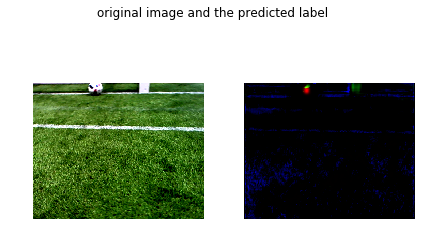

Epoch 2/100
----------
Mean Squared Error Loss: 2778.6500 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2284.4934 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1792.4222 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 3189.4996 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1184.6592 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 3656.6582 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1426.7560 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1707.8421 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 3037.8156 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 3461.3643 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 3033.6671 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1467.1704 * 1e-03  [2880/2992 (96%)]
Time elapsed: 7m 47s

Average test Loss: 644.2539 * 1e-03
Average test metrics->RC_ball:44.3, FDR_ball:0.0, RC_goalpost:0.0, FDR_goalpost:0.0, RC_robot:39.5, FDR_robot:31.0 
Time elapsed: 8m 8s



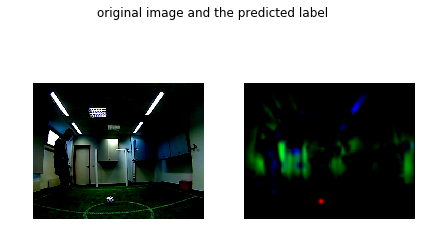

Epoch 3/100
----------
Mean Squared Error Loss: 1298.5593 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 3314.7190 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 761.7981 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1333.1714 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1357.6851 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 2587.0934 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2013.6025 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 3172.5769 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1876.1286 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1927.7802 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2486.5146 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1956.8286 * 1e-03  [2880/2992 (96%)]
Time elapsed: 11m 49s

Average test Loss: 999.3027 * 1e-03
Average test metrics->RC_ball:63.7, FDR_ball:0.0, RC_goalpost:23.4, FDR_goalpost:59.5, RC_robot:46.5, FDR_robot:35.8 
Time elapsed: 12m 10s



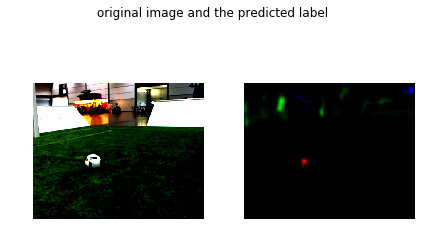

Epoch 4/100
----------
Mean Squared Error Loss: 1453.9844 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2734.6137 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1312.4298 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2855.1810 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 859.1757 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 2750.7052 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1041.0415 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 3034.2429 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2687.7971 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2270.1480 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1508.0720 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1443.3800 * 1e-03  [2880/2992 (96%)]
Time elapsed: 15m 58s

Average test Loss: 1131.8709 * 1e-03
Average test metrics->RC_ball:85.3, FDR_ball:0.0, RC_goalpost:24.6, FDR_goalpost:35.0, RC_robot:40.9, FDR_robot:13.6 
Time elapsed: 16m 20s



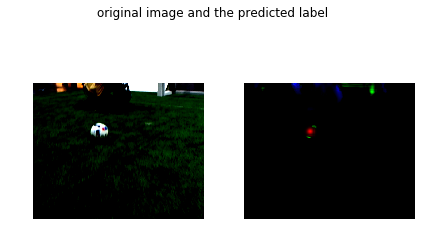

Epoch 5/100
----------
Mean Squared Error Loss: 1743.9204 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1264.2277 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2636.9903 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1735.7235 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 2446.9614 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 3615.9809 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1389.0654 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1418.8688 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1446.5978 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2216.0940 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 719.3171 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 2632.6790 * 1e-03  [2880/2992 (96%)]
Time elapsed: 20m 5s

Average test Loss: 1196.0276 * 1e-03
Average test metrics->RC_ball:90.9, FDR_ball:3.2, RC_goalpost:20.7, FDR_goalpost:30.5, RC_robot:47.6, FDR_robot:8.6 
Time elapsed: 20m 26s



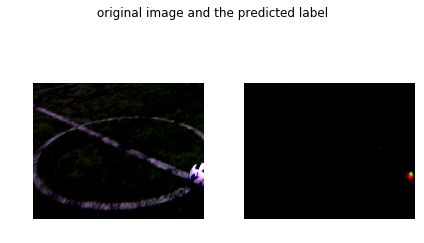

Epoch 6/100
----------
Mean Squared Error Loss: 2265.2059 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1618.2129 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1936.3724 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1812.7153 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 2109.4255 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 972.9074 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1800.5310 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2244.4158 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1218.0077 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 740.7168 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 3245.2216 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1318.5806 * 1e-03  [2880/2992 (96%)]
Time elapsed: 24m 7s

Average test Loss: 1070.4226 * 1e-03
Average test metrics->RC_ball:90.7, FDR_ball:2.3, RC_goalpost:24.3, FDR_goalpost:28.5, RC_robot:52.8, FDR_robot:18.5 
Time elapsed: 24m 28s



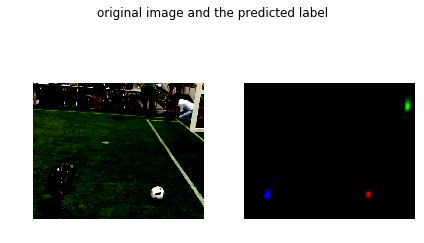

Epoch 7/100
----------
Mean Squared Error Loss: 1674.3921 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1293.0737 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1001.8338 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2530.4239 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1635.9571 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1803.2740 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2631.9375 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 641.3654 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1959.0551 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1021.1110 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1690.9842 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 2331.2747 * 1e-03  [2880/2992 (96%)]
Time elapsed: 28m 12s

Average test Loss: 1328.9797 * 1e-03
Average test metrics->RC_ball:88.4, FDR_ball:0.6, RC_goalpost:37.9, FDR_goalpost:42.0, RC_robot:57.1, FDR_robot:9.8 
Time elapsed: 28m 33s



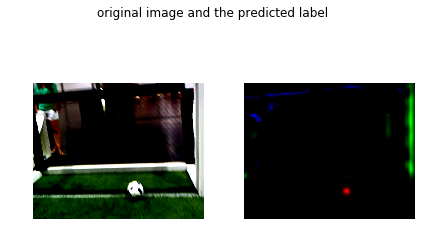

Epoch 8/100
----------
Mean Squared Error Loss: 2364.7683 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2058.3539 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2476.5499 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 3011.8206 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1337.9748 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1564.1091 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1911.4636 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1028.3941 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1023.4169 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2088.5630 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1587.8447 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1124.1883 * 1e-03  [2880/2992 (96%)]
Time elapsed: 32m 16s

Average test Loss: 1289.2150 * 1e-03
Average test metrics->RC_ball:89.8, FDR_ball:0.0, RC_goalpost:44.4, FDR_goalpost:32.8, RC_robot:52.1, FDR_robot:16.4 
Time elapsed: 32m 37s



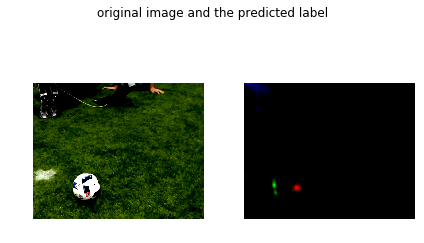

Epoch 9/100
----------
Mean Squared Error Loss: 3116.9596 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 3799.5915 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2281.9240 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1483.2084 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1214.4740 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 3226.6843 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1346.2220 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2841.4419 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2114.7013 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1336.7729 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1122.9962 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1817.4424 * 1e-03  [2880/2992 (96%)]
Time elapsed: 36m 23s

Average test Loss: 1415.4314 * 1e-03
Average test metrics->RC_ball:91.7, FDR_ball:0.0, RC_goalpost:37.5, FDR_goalpost:31.7, RC_robot:62.3, FDR_robot:12.4 
Time elapsed: 36m 44s



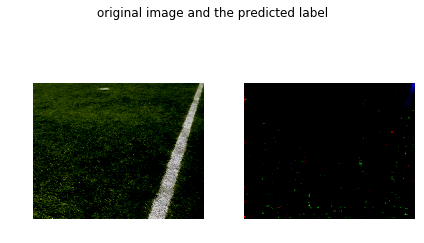

Epoch 10/100
----------
Mean Squared Error Loss: 513.6183 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 956.7917 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1581.0057 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2203.0747 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1345.1924 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1042.9692 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2627.5868 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1410.7836 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 488.3057 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1240.6441 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2707.1395 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 3025.9662 * 1e-03  [2880/2992 (96%)]
Time elapsed: 40m 29s

Average test Loss: 1552.6884 * 1e-03
Average test metrics->RC_ball:93.7, FDR_ball:1.1, RC_goalpost:49.2, FDR_goalpost:28.9, RC_robot:58.0, FDR_robot:15.0 
Time elapsed: 40m 51s



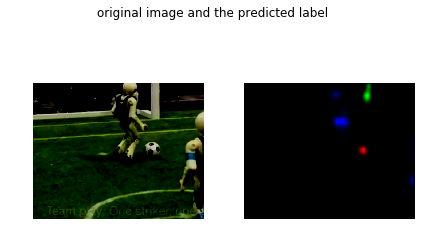

Epoch 11/100
----------
Mean Squared Error Loss: 1246.5671 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2083.2736 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2961.6601 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1215.4117 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1334.0700 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 646.7745 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 919.2057 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1226.0976 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 581.7443 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2108.8042 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1461.4142 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 2561.7526 * 1e-03  [2880/2992 (96%)]
Time elapsed: 44m 37s

Average test Loss: 1485.4789 * 1e-03
Average test metrics->RC_ball:93.3, FDR_ball:0.0, RC_goalpost:46.1, FDR_goalpost:37.1, RC_robot:58.4, FDR_robot:18.4 
Time elapsed: 44m 58s



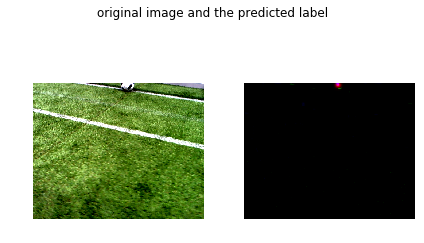

Epoch 12/100
----------
Mean Squared Error Loss: 1530.8223 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 923.6925 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1364.5973 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 657.5630 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1825.9945 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1373.7260 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1649.5614 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 3736.6359 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1498.3115 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1622.7356 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1567.0224 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 3772.9671 * 1e-03  [2880/2992 (96%)]
Time elapsed: 48m 44s

Average test Loss: 1804.5132 * 1e-03
Average test metrics->RC_ball:90.5, FDR_ball:0.3, RC_goalpost:54.0, FDR_goalpost:50.5, RC_robot:59.4, FDR_robot:19.9 
Time elapsed: 49m 6s



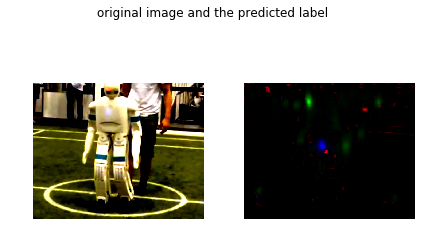

Epoch 13/100
----------
Mean Squared Error Loss: 1180.2094 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1983.1320 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1416.7671 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2760.3755 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1854.3123 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 2686.7392 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2409.9455 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1035.8387 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1574.9832 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1859.7776 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1968.8138 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 2183.2633 * 1e-03  [2880/2992 (96%)]
Time elapsed: 52m 51s

Average test Loss: 2118.1300 * 1e-03
Average test metrics->RC_ball:95.1, FDR_ball:0.0, RC_goalpost:52.6, FDR_goalpost:42.6, RC_robot:66.6, FDR_robot:11.3 
Time elapsed: 53m 13s



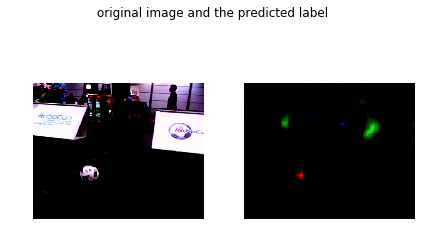

Epoch 14/100
----------
Mean Squared Error Loss: 2046.4656 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1456.6653 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1538.0528 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2206.1436 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 4199.6174 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1482.1923 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1689.0645 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2958.8838 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 997.8006 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1489.5613 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1372.2626 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1418.2167 * 1e-03  [2880/2992 (96%)]
Time elapsed: 56m 53s

Average test Loss: 1515.8983 * 1e-03
Average test metrics->RC_ball:91.6, FDR_ball:0.0, RC_goalpost:47.2, FDR_goalpost:22.4, RC_robot:64.6, FDR_robot:9.2 
Time elapsed: 57m 14s



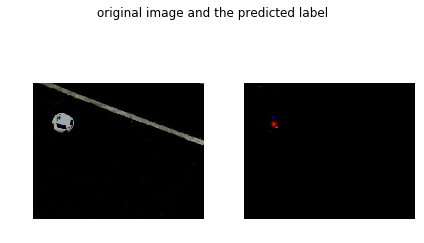

Epoch 15/100
----------
Mean Squared Error Loss: 750.7428 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1383.4569 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2239.8584 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1364.6511 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 2920.3773 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1083.4949 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 943.9567 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1007.8653 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1353.4385 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2933.7783 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1952.1829 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1721.1704 * 1e-03  [2880/2992 (96%)]
Time elapsed: 60m 54s

Average test Loss: 1571.6502 * 1e-03
Average test metrics->RC_ball:93.1, FDR_ball:0.0, RC_goalpost:43.7, FDR_goalpost:35.9, RC_robot:70.2, FDR_robot:17.3 
Time elapsed: 61m 15s



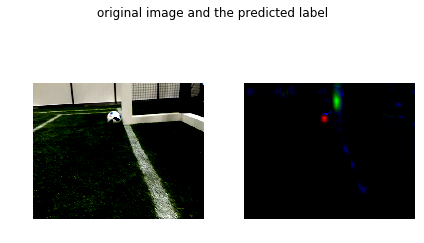

Epoch 16/100
----------
Mean Squared Error Loss: 3606.6535 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 919.8664 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1023.3501 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1256.8843 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1287.7394 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1117.6242 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2080.0023 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 700.9658 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2074.2934 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1690.1169 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1237.2516 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1676.3933 * 1e-03  [2880/2992 (96%)]
Time elapsed: 64m 56s

Average test Loss: 1428.0808 * 1e-03
Average test metrics->RC_ball:93.3, FDR_ball:0.0, RC_goalpost:46.5, FDR_goalpost:25.2, RC_robot:69.0, FDR_robot:8.5 
Time elapsed: 65m 17s



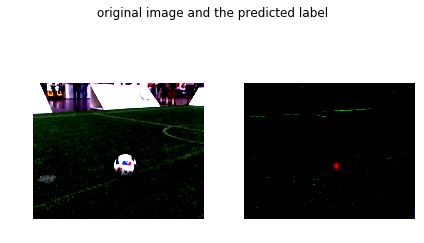

Epoch 17/100
----------
Mean Squared Error Loss: 910.9478 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 850.1719 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2644.7380 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1032.9499 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 820.1941 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1005.0645 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1018.0446 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1328.8296 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 927.2296 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 880.7195 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1581.0277 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 2719.7831 * 1e-03  [2880/2992 (96%)]
Time elapsed: 68m 57s

Average test Loss: 1498.1171 * 1e-03
Average test metrics->RC_ball:92.0, FDR_ball:0.0, RC_goalpost:48.2, FDR_goalpost:34.6, RC_robot:60.3, FDR_robot:7.7 
Time elapsed: 69m 18s



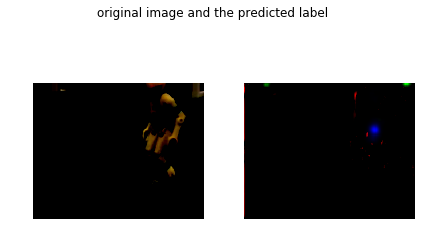

Epoch 18/100
----------
Mean Squared Error Loss: 648.3805 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 841.5427 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1200.9239 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1215.6547 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1244.3815 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 2202.8360 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 663.1256 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 457.7441 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 464.5568 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1538.4233 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 970.7819 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 794.0086 * 1e-03  [2880/2992 (96%)]
Time elapsed: 72m 59s

Average test Loss: 1841.1978 * 1e-03
Average test metrics->RC_ball:93.9, FDR_ball:0.0, RC_goalpost:68.2, FDR_goalpost:44.7, RC_robot:72.3, FDR_robot:10.3 
Time elapsed: 73m 20s



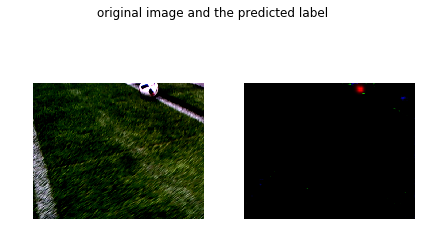

Epoch 19/100
----------
Mean Squared Error Loss: 723.7109 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 760.5898 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1752.9178 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1593.0661 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1553.1858 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1326.1359 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1551.7720 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1501.4763 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1011.5710 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1204.9481 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1631.9746 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 761.1735 * 1e-03  [2880/2992 (96%)]
Time elapsed: 76m 60s

Average test Loss: 1789.3226 * 1e-03
Average test metrics->RC_ball:94.4, FDR_ball:0.0, RC_goalpost:53.6, FDR_goalpost:32.1, RC_robot:74.3, FDR_robot:13.2 
Time elapsed: 77m 21s



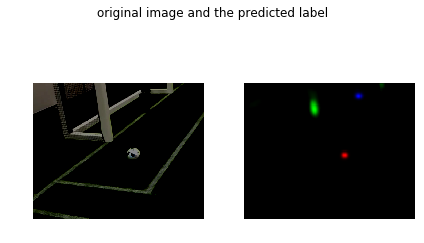

Epoch 20/100
----------
Mean Squared Error Loss: 2028.8830 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2090.8687 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1639.7812 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1385.7509 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1229.6396 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 948.2506 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1546.7931 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2243.0992 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1496.0002 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2271.1923 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 730.2741 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1323.9516 * 1e-03  [2880/2992 (96%)]
Time elapsed: 81m 2s

Average test Loss: 1565.2886 * 1e-03
Average test metrics->RC_ball:93.2, FDR_ball:0.4, RC_goalpost:53.5, FDR_goalpost:34.1, RC_robot:70.2, FDR_robot:6.1 
Time elapsed: 81m 24s



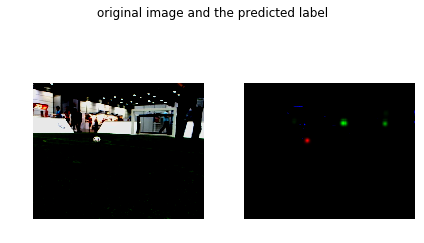

Epoch 21/100
----------
Mean Squared Error Loss: 1226.7039 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1391.7035 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1400.8423 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 999.2939 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 2195.0431 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 677.7700 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 788.9664 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1411.8637 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2313.1943 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 768.1064 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2109.5567 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1406.4153 * 1e-03  [2880/2992 (96%)]
Time elapsed: 85m 10s

Average test Loss: 1674.2134 * 1e-03
Average test metrics->RC_ball:93.8, FDR_ball:0.4, RC_goalpost:47.9, FDR_goalpost:30.0, RC_robot:71.7, FDR_robot:20.6 
Time elapsed: 85m 31s



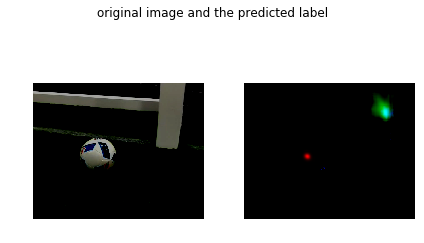

Epoch 22/100
----------
Mean Squared Error Loss: 1323.8157 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 596.6788 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1007.1119 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 472.1238 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 749.6207 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1052.3059 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1781.3684 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 717.2517 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1025.9496 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1458.7001 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 940.5138 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1866.1879 * 1e-03  [2880/2992 (96%)]
Time elapsed: 89m 16s

Average test Loss: 1534.1720 * 1e-03
Average test metrics->RC_ball:94.5, FDR_ball:0.0, RC_goalpost:60.9, FDR_goalpost:37.4, RC_robot:71.0, FDR_robot:9.8 
Time elapsed: 89m 38s



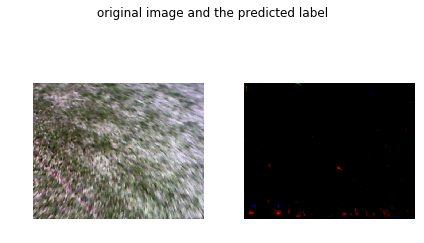

Epoch 23/100
----------
Mean Squared Error Loss: 457.8644 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2087.1828 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1576.0647 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1887.9262 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1143.6437 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1299.0544 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1612.0944 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2176.0759 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 759.2693 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1584.9779 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 978.8371 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1191.5364 * 1e-03  [2880/2992 (96%)]
Time elapsed: 93m 23s

Average test Loss: 1639.8320 * 1e-03
Average test metrics->RC_ball:93.9, FDR_ball:0.0, RC_goalpost:56.4, FDR_goalpost:32.7, RC_robot:68.2, FDR_robot:14.0 
Time elapsed: 93m 44s



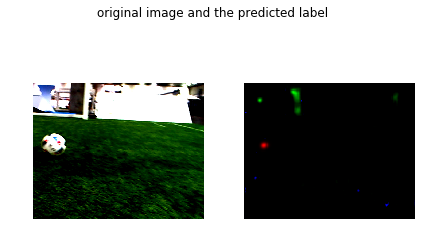

Epoch 24/100
----------
Mean Squared Error Loss: 1698.9387 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1010.3471 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 702.8683 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 908.5777 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1535.8847 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1165.8496 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1483.1884 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2481.2963 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1261.6138 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 931.8674 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1870.2997 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1209.3832 * 1e-03  [2880/2992 (96%)]
Time elapsed: 97m 28s

Average test Loss: 1758.8614 * 1e-03
Average test metrics->RC_ball:93.7, FDR_ball:0.0, RC_goalpost:61.9, FDR_goalpost:39.3, RC_robot:71.5, FDR_robot:10.2 
Time elapsed: 97m 50s



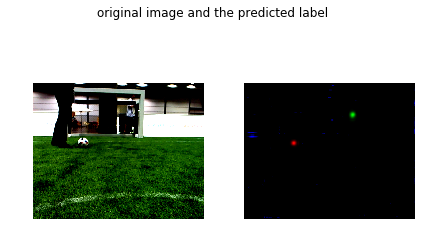

Epoch 25/100
----------
Mean Squared Error Loss: 913.9605 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 891.4056 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 484.5993 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1249.2907 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1760.0008 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 619.6319 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1026.8501 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 854.0739 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1547.3703 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1127.3248 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 3328.3122 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1346.9121 * 1e-03  [2880/2992 (96%)]
Time elapsed: 101m 31s

Average test Loss: 2244.4377 * 1e-03
Average test metrics->RC_ball:94.5, FDR_ball:0.0, RC_goalpost:59.5, FDR_goalpost:26.3, RC_robot:70.9, FDR_robot:17.7 
Time elapsed: 101m 52s



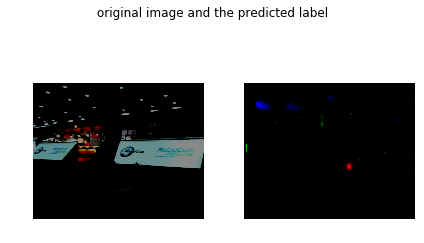

Epoch 26/100
----------
Mean Squared Error Loss: 788.6342 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1097.8712 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2121.3951 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1717.0819 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1217.2520 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 3511.0328 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1055.3071 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1509.3664 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1120.9346 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1373.8390 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1702.9662 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1099.8524 * 1e-03  [2880/2992 (96%)]
Time elapsed: 105m 33s

Average test Loss: 2279.8342 * 1e-03
Average test metrics->RC_ball:94.2, FDR_ball:0.6, RC_goalpost:59.1, FDR_goalpost:20.4, RC_robot:66.9, FDR_robot:19.8 
Time elapsed: 105m 55s



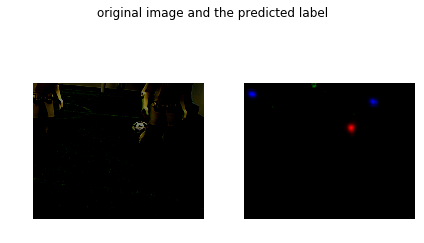

Epoch 27/100
----------
Mean Squared Error Loss: 1023.6565 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 957.6616 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1183.4142 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 768.8728 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1063.8864 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1262.6492 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1045.0648 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 919.9218 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1000.2893 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1002.0537 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1712.3599 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 767.0431 * 1e-03  [2880/2992 (96%)]
Time elapsed: 109m 35s

Average test Loss: 1738.8455 * 1e-03
Average test metrics->RC_ball:93.8, FDR_ball:0.3, RC_goalpost:52.8, FDR_goalpost:18.3, RC_robot:70.9, FDR_robot:16.5 
Time elapsed: 109m 56s



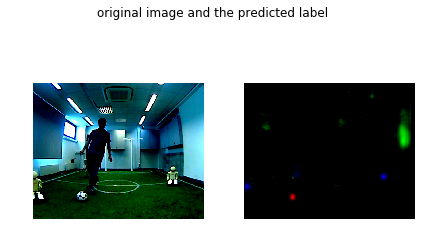

Epoch 28/100
----------
Mean Squared Error Loss: 1529.2114 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1232.2830 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1089.8857 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 799.1475 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1584.0707 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1620.9722 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1743.4688 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1302.9785 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1308.3344 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 563.0344 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 836.1021 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1693.4937 * 1e-03  [2880/2992 (96%)]
Time elapsed: 113m 40s

Average test Loss: 1899.2263 * 1e-03
Average test metrics->RC_ball:93.0, FDR_ball:0.4, RC_goalpost:64.5, FDR_goalpost:41.1, RC_robot:76.3, FDR_robot:13.5 
Time elapsed: 114m 1s



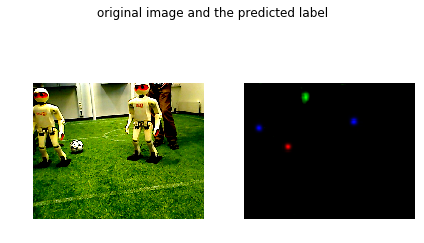

Epoch 29/100
----------
Mean Squared Error Loss: 1057.5529 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2158.3009 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1093.4275 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1907.4866 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 513.7125 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1150.1143 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2803.9274 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 752.3142 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1161.9884 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 656.3153 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1932.3987 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 723.9208 * 1e-03  [2880/2992 (96%)]
Time elapsed: 117m 42s

Average test Loss: 1702.4776 * 1e-03
Average test metrics->RC_ball:92.4, FDR_ball:0.0, RC_goalpost:62.6, FDR_goalpost:30.3, RC_robot:72.7, FDR_robot:13.9 
Time elapsed: 118m 3s



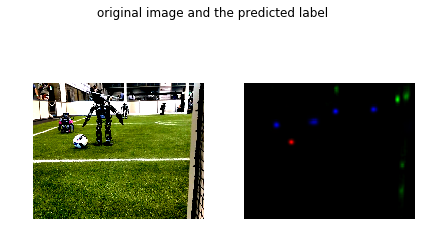

Epoch 30/100
----------
Mean Squared Error Loss: 595.9253 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1652.4612 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1787.0044 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1046.3365 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 2192.7161 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1845.7835 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 815.2911 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1479.8722 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1031.4344 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1226.9061 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 504.5165 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1040.8576 * 1e-03  [2880/2992 (96%)]
Time elapsed: 121m 49s

Average test Loss: 1651.1676 * 1e-03
Average test metrics->RC_ball:95.2, FDR_ball:0.3, RC_goalpost:62.0, FDR_goalpost:30.3, RC_robot:76.7, FDR_robot:15.8 
Time elapsed: 122m 10s



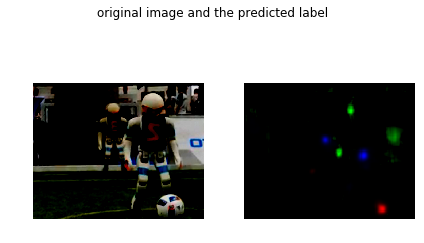

Epoch 31/100
----------
Mean Squared Error Loss: 1431.6182 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1037.3666 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2305.2325 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1180.8527 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1756.6167 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1717.4928 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 854.5258 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 686.7104 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1573.8703 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 964.9282 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 677.8761 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1992.0278 * 1e-03  [2880/2992 (96%)]
Time elapsed: 125m 55s

Average test Loss: 2134.2415 * 1e-03
Average test metrics->RC_ball:95.5, FDR_ball:0.0, RC_goalpost:65.1, FDR_goalpost:33.3, RC_robot:66.7, FDR_robot:8.1 
Time elapsed: 126m 16s



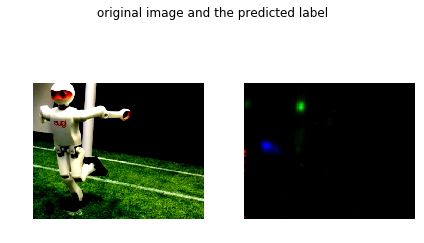

Epoch 32/100
----------
Mean Squared Error Loss: 555.0584 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 575.7037 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1856.1436 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1001.0045 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1038.3918 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 713.3743 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 616.0015 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1295.3951 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1217.9304 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1649.8851 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1051.5792 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 534.5028 * 1e-03  [2880/2992 (96%)]
Time elapsed: 130m 2s

Average test Loss: 2243.2665 * 1e-03
Average test metrics->RC_ball:96.0, FDR_ball:0.3, RC_goalpost:64.5, FDR_goalpost:38.4, RC_robot:79.1, FDR_robot:14.2 
Time elapsed: 130m 23s



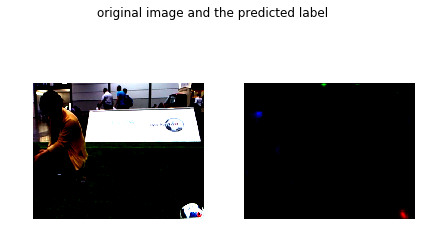

Epoch 33/100
----------
Mean Squared Error Loss: 1272.6424 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1245.2309 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1219.9516 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1702.2121 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1123.4990 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1076.9715 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1294.8736 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 954.4999 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2126.6725 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1626.1871 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2707.4022 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 964.3630 * 1e-03  [2880/2992 (96%)]
Time elapsed: 134m 9s

Average test Loss: 1922.3012 * 1e-03
Average test metrics->RC_ball:94.5, FDR_ball:1.2, RC_goalpost:62.3, FDR_goalpost:22.9, RC_robot:76.5, FDR_robot:9.4 
Time elapsed: 134m 31s



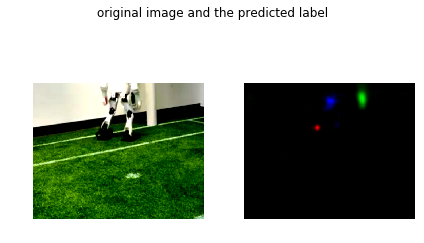

Epoch 34/100
----------
Mean Squared Error Loss: 1116.1009 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2107.2390 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 753.4477 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 450.3747 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 625.4489 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 2632.4811 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 559.9127 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1205.9879 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 922.2488 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1315.4460 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 520.2490 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 816.7473 * 1e-03  [2880/2992 (96%)]
Time elapsed: 138m 17s

Average test Loss: 2281.1366 * 1e-03
Average test metrics->RC_ball:95.2, FDR_ball:0.3, RC_goalpost:69.6, FDR_goalpost:39.5, RC_robot:76.2, FDR_robot:23.3 
Time elapsed: 138m 38s



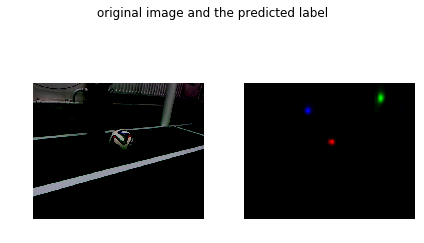

Epoch 35/100
----------
Mean Squared Error Loss: 824.4883 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2297.4575 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 529.9398 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1471.7731 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1680.3551 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1372.4664 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1053.2621 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1450.4670 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1534.7326 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1453.1876 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1038.6071 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 678.9410 * 1e-03  [2880/2992 (96%)]
Time elapsed: 142m 23s

Average test Loss: 1936.9144 * 1e-03
Average test metrics->RC_ball:96.9, FDR_ball:0.3, RC_goalpost:67.0, FDR_goalpost:38.0, RC_robot:74.9, FDR_robot:12.6 
Time elapsed: 142m 44s



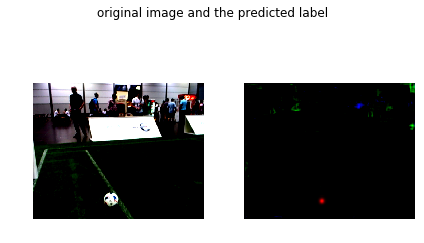

Epoch 36/100
----------
Mean Squared Error Loss: 2842.2759 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 3531.3699 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1855.9676 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1418.3487 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 916.2607 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1000.0416 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 550.5682 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1176.0604 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2054.3830 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 810.8031 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1245.4143 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 941.9096 * 1e-03  [2880/2992 (96%)]
Time elapsed: 146m 24s

Average test Loss: 1802.0251 * 1e-03
Average test metrics->RC_ball:91.2, FDR_ball:0.0, RC_goalpost:61.6, FDR_goalpost:25.6, RC_robot:74.5, FDR_robot:16.0 
Time elapsed: 146m 45s



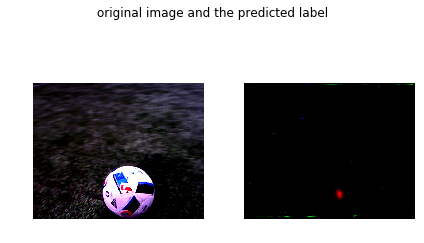

Epoch 37/100
----------
Mean Squared Error Loss: 992.2469 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1582.8940 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 996.4658 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1412.2814 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 616.3782 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 545.5349 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2186.3673 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 3483.1696 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1545.6303 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2135.0949 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 942.8333 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 504.5087 * 1e-03  [2880/2992 (96%)]
Time elapsed: 150m 29s

Average test Loss: 2231.7548 * 1e-03
Average test metrics->RC_ball:94.1, FDR_ball:0.0, RC_goalpost:69.8, FDR_goalpost:33.7, RC_robot:76.7, FDR_robot:9.8 
Time elapsed: 150m 51s



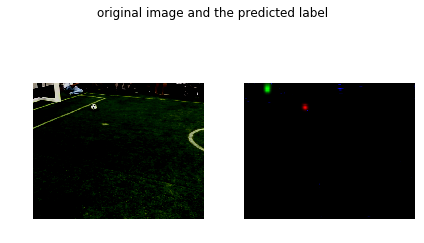

Epoch 38/100
----------
Mean Squared Error Loss: 2008.8122 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1203.0507 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 589.9707 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 302.8400 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 784.5820 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 275.8927 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2232.9545 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1014.1355 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 989.7277 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2229.3773 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2537.4188 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 491.3326 * 1e-03  [2880/2992 (96%)]
Time elapsed: 154m 35s

Average test Loss: 1746.6538 * 1e-03
Average test metrics->RC_ball:94.9, FDR_ball:0.0, RC_goalpost:67.6, FDR_goalpost:26.1, RC_robot:71.6, FDR_robot:25.4 
Time elapsed: 154m 56s



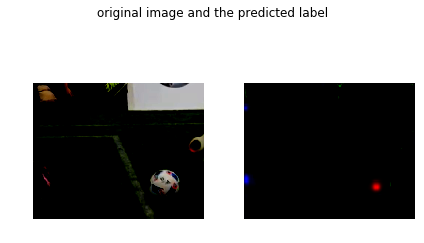

Epoch 39/100
----------
Mean Squared Error Loss: 680.5507 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1031.8456 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 514.3799 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 958.5983 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1908.7052 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1659.4198 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 415.5733 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 817.0107 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1502.4037 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 722.8033 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2413.3570 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1396.7414 * 1e-03  [2880/2992 (96%)]
Time elapsed: 158m 37s

Average test Loss: 1735.3358 * 1e-03
Average test metrics->RC_ball:95.3, FDR_ball:0.7, RC_goalpost:54.2, FDR_goalpost:39.0, RC_robot:76.7, FDR_robot:13.5 
Time elapsed: 158m 58s



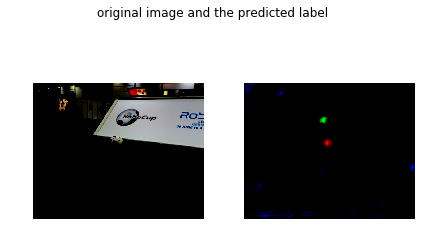

Epoch 40/100
----------
Mean Squared Error Loss: 682.1555 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1219.2966 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 765.7627 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1162.0502 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 786.1768 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 804.9147 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1084.9481 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 575.4005 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 966.6048 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1459.3347 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 812.2480 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1323.3107 * 1e-03  [2880/2992 (96%)]
Time elapsed: 162m 39s

Average test Loss: 1826.7955 * 1e-03
Average test metrics->RC_ball:93.5, FDR_ball:0.6, RC_goalpost:56.8, FDR_goalpost:27.9, RC_robot:78.2, FDR_robot:8.3 
Time elapsed: 162m 60s



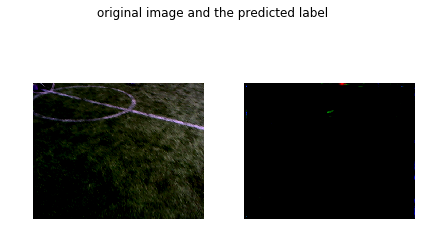

Epoch 41/100
----------
Mean Squared Error Loss: 1504.8008 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 821.5498 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 805.3173 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 535.9925 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 468.9819 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 699.9786 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 615.1823 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 436.1150 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1209.2494 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1499.5464 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 596.3056 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 898.2474 * 1e-03  [2880/2992 (96%)]
Time elapsed: 166m 40s

Average test Loss: 1901.4611 * 1e-03
Average test metrics->RC_ball:94.2, FDR_ball:0.0, RC_goalpost:64.7, FDR_goalpost:42.3, RC_robot:72.6, FDR_robot:17.4 
Time elapsed: 167m 1s



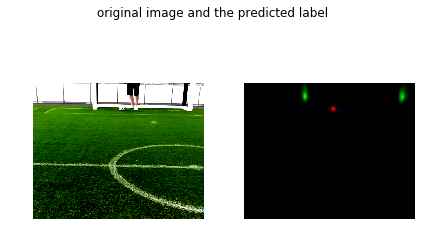

Epoch 42/100
----------
Mean Squared Error Loss: 1750.6653 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 565.6926 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 364.7504 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1043.9947 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1239.4294 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 428.9537 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1319.3644 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1262.1826 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1917.4178 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 909.0649 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1454.2185 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1650.1968 * 1e-03  [2880/2992 (96%)]
Time elapsed: 170m 42s

Average test Loss: 2129.2555 * 1e-03
Average test metrics->RC_ball:95.4, FDR_ball:0.0, RC_goalpost:62.5, FDR_goalpost:26.4, RC_robot:73.5, FDR_robot:18.6 
Time elapsed: 171m 3s



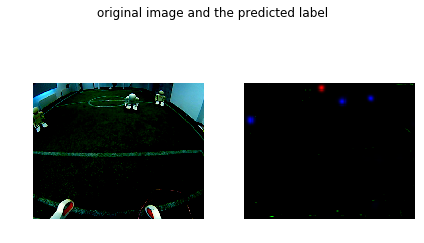

Epoch 43/100
----------
Mean Squared Error Loss: 1770.9094 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1119.0923 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1227.8866 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 717.4779 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 914.3738 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 366.7426 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 408.3748 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 611.7706 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1859.2366 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1118.7580 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1229.0708 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 784.5343 * 1e-03  [2880/2992 (96%)]
Time elapsed: 174m 45s

Average test Loss: 2025.6684 * 1e-03
Average test metrics->RC_ball:95.5, FDR_ball:0.0, RC_goalpost:69.5, FDR_goalpost:36.8, RC_robot:77.9, FDR_robot:9.4 
Time elapsed: 175m 6s



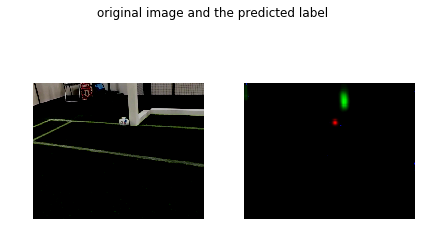

Epoch 44/100
----------
Mean Squared Error Loss: 1884.9390 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2450.9163 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1434.0802 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 653.0247 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1772.9719 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 869.2858 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1141.2479 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2052.7523 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 566.9721 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 983.7063 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1188.5300 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 541.1614 * 1e-03  [2880/2992 (96%)]
Time elapsed: 178m 52s

Average test Loss: 1848.8283 * 1e-03
Average test metrics->RC_ball:95.9, FDR_ball:0.5, RC_goalpost:72.8, FDR_goalpost:33.4, RC_robot:77.9, FDR_robot:9.3 
Time elapsed: 179m 14s



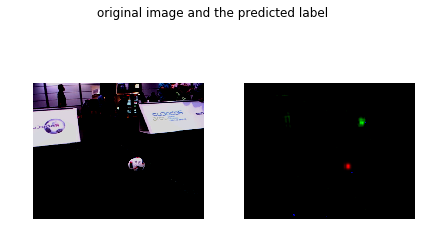

Epoch 45/100
----------
Mean Squared Error Loss: 1540.2663 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 973.4103 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1574.1537 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 477.4537 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 930.0193 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1990.9139 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1385.4814 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 802.9327 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1225.7272 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 882.7207 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1390.1559 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 856.0362 * 1e-03  [2880/2992 (96%)]
Time elapsed: 183m 0s

Average test Loss: 2183.5765 * 1e-03
Average test metrics->RC_ball:94.9, FDR_ball:0.0, RC_goalpost:64.8, FDR_goalpost:29.3, RC_robot:75.8, FDR_robot:22.4 
Time elapsed: 183m 22s



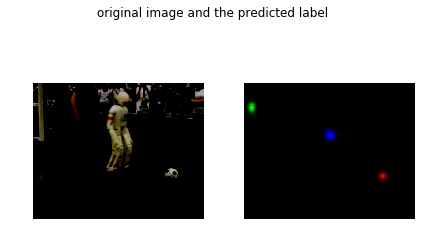

Epoch 46/100
----------
Mean Squared Error Loss: 2559.3190 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 733.1882 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 859.3309 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2179.5416 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 841.1095 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 599.0960 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 606.2299 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1227.3815 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 656.9644 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 607.0860 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 473.3001 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1266.1921 * 1e-03  [2880/2992 (96%)]
Time elapsed: 187m 7s

Average test Loss: 1925.7781 * 1e-03
Average test metrics->RC_ball:96.3, FDR_ball:0.0, RC_goalpost:70.8, FDR_goalpost:27.5, RC_robot:71.6, FDR_robot:7.2 
Time elapsed: 187m 28s



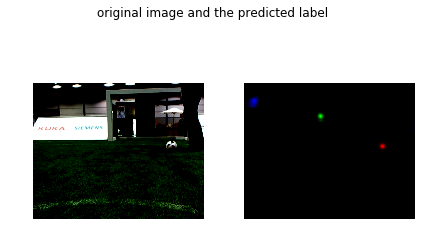

Epoch 47/100
----------
Mean Squared Error Loss: 556.9880 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1382.7878 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 3180.2440 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1036.2507 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1038.0025 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 274.8142 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1033.9485 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 917.5587 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1116.6495 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 570.1457 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1441.9079 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 969.4319 * 1e-03  [2880/2992 (96%)]
Time elapsed: 191m 8s

Average test Loss: 2446.3158 * 1e-03
Average test metrics->RC_ball:94.2, FDR_ball:0.7, RC_goalpost:63.9, FDR_goalpost:33.4, RC_robot:78.3, FDR_robot:18.5 
Time elapsed: 191m 29s



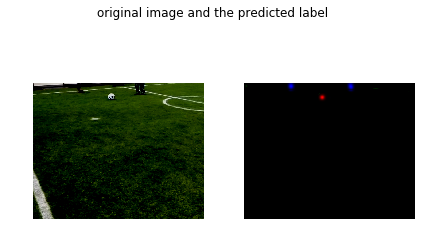

Epoch 48/100
----------
Mean Squared Error Loss: 1195.2002 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 992.7031 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1819.0460 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 3172.1463 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 985.1815 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 862.4409 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 650.8241 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1219.2184 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 482.4067 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2008.9209 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2201.8943 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1136.4418 * 1e-03  [2880/2992 (96%)]
Time elapsed: 195m 12s

Average test Loss: 2262.8596 * 1e-03
Average test metrics->RC_ball:93.9, FDR_ball:0.4, RC_goalpost:71.5, FDR_goalpost:29.8, RC_robot:82.8, FDR_robot:11.7 
Time elapsed: 195m 33s



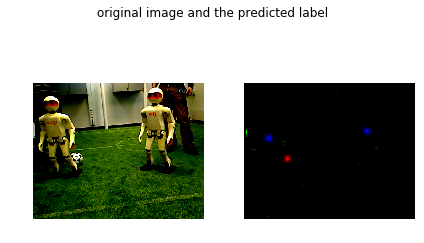

Epoch 49/100
----------
Mean Squared Error Loss: 973.1240 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2119.6671 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2063.4449 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 828.4996 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 2657.8813 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1939.4468 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 749.2226 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 653.7132 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 959.8472 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1568.8288 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 3453.6271 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 2008.5223 * 1e-03  [2880/2992 (96%)]
Time elapsed: 199m 14s

Average test Loss: 2033.3181 * 1e-03
Average test metrics->RC_ball:94.1, FDR_ball:0.0, RC_goalpost:62.2, FDR_goalpost:24.2, RC_robot:81.3, FDR_robot:12.1 
Time elapsed: 199m 35s



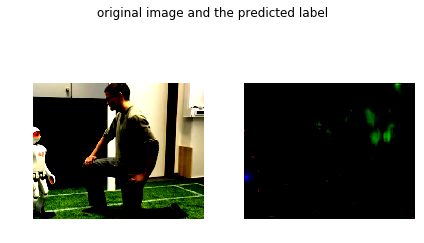

Epoch 50/100
----------
Mean Squared Error Loss: 1060.7914 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2400.4378 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 483.4922 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1385.3259 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1054.9158 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 686.5376 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 835.4658 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1454.3796 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 500.0134 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 902.7015 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 509.8660 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1436.5290 * 1e-03  [2880/2992 (96%)]
Time elapsed: 203m 19s

Average test Loss: 2098.5682 * 1e-03
Average test metrics->RC_ball:95.2, FDR_ball:0.4, RC_goalpost:67.5, FDR_goalpost:22.6, RC_robot:75.6, FDR_robot:11.0 
Time elapsed: 203m 41s



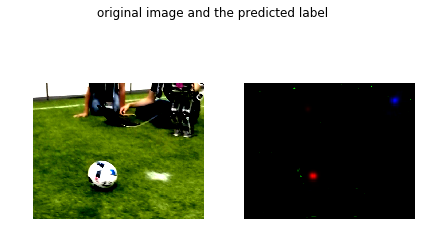

Epoch 51/100
----------
Mean Squared Error Loss: 1324.4398 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 940.1914 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2409.5843 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1383.9612 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1183.3616 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 808.8779 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 697.1368 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 779.4704 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 506.5045 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1366.5761 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1617.1416 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1121.2521 * 1e-03  [2880/2992 (96%)]
Time elapsed: 207m 21s

Average test Loss: 1892.8964 * 1e-03
Average test metrics->RC_ball:95.5, FDR_ball:2.1, RC_goalpost:64.3, FDR_goalpost:32.7, RC_robot:79.4, FDR_robot:13.5 
Time elapsed: 207m 42s



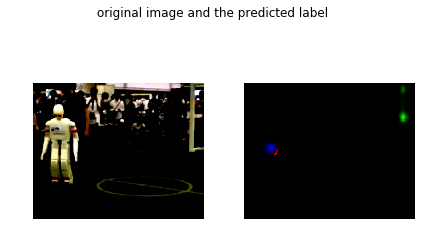

Epoch 52/100
----------
Mean Squared Error Loss: 1510.4578 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1443.0975 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 845.5731 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1220.3506 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 944.1732 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 779.8688 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1125.1696 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1232.6106 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 752.6542 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1280.2092 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1036.7895 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 794.0528 * 1e-03  [2880/2992 (96%)]
Time elapsed: 211m 28s

Average test Loss: 2151.9784 * 1e-03
Average test metrics->RC_ball:94.9, FDR_ball:0.0, RC_goalpost:66.6, FDR_goalpost:32.7, RC_robot:84.2, FDR_robot:11.5 
Time elapsed: 211m 50s



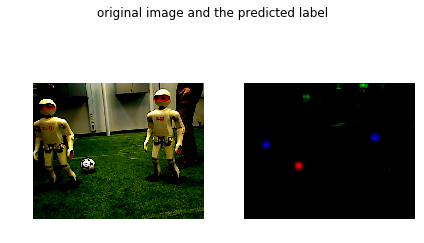

Epoch 53/100
----------
Mean Squared Error Loss: 753.1968 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 914.3886 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 790.6958 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 994.6639 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 426.2110 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1295.2200 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1218.0238 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 969.3893 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 540.5220 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 3496.0527 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 942.3427 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 678.4819 * 1e-03  [2880/2992 (96%)]
Time elapsed: 215m 37s

Average test Loss: 1893.2364 * 1e-03
Average test metrics->RC_ball:92.4, FDR_ball:0.0, RC_goalpost:69.8, FDR_goalpost:33.4, RC_robot:82.3, FDR_robot:18.1 
Time elapsed: 215m 59s



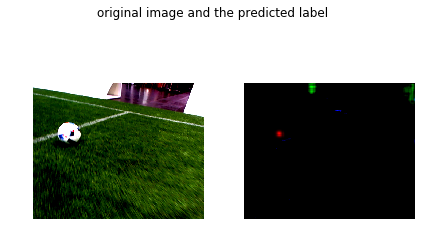

Epoch 54/100
----------
Mean Squared Error Loss: 689.4926 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1574.9547 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1541.7134 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1690.3071 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1593.3548 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 472.2141 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 906.9701 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1542.3474 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1036.3597 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 958.7196 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 978.7493 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 949.5862 * 1e-03  [2880/2992 (96%)]
Time elapsed: 219m 48s

Average test Loss: 1973.5401 * 1e-03
Average test metrics->RC_ball:94.6, FDR_ball:0.0, RC_goalpost:71.1, FDR_goalpost:27.6, RC_robot:81.8, FDR_robot:8.1 
Time elapsed: 220m 10s



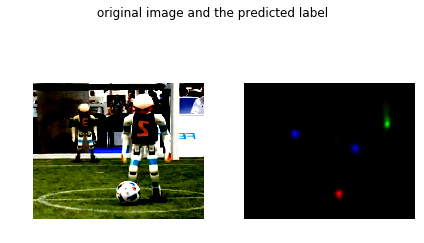

Epoch 55/100
----------
Mean Squared Error Loss: 1440.6841 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1010.7024 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 680.8299 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 728.4263 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 608.6586 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 927.2352 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1682.7786 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 928.1919 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 685.5480 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1061.1975 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2039.8989 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1179.8167 * 1e-03  [2880/2992 (96%)]
Time elapsed: 223m 57s

Average test Loss: 1905.5348 * 1e-03
Average test metrics->RC_ball:95.0, FDR_ball:0.0, RC_goalpost:68.1, FDR_goalpost:39.0, RC_robot:75.4, FDR_robot:8.7 
Time elapsed: 224m 18s



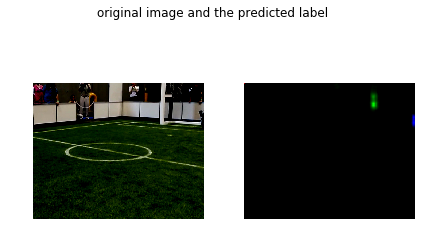

Epoch 56/100
----------
Mean Squared Error Loss: 1784.5848 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1342.4164 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 910.4302 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1211.7164 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 753.9340 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 941.6767 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1348.5758 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 781.0766 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2121.9797 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1294.8577 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1469.7263 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1300.1250 * 1e-03  [2880/2992 (96%)]
Time elapsed: 228m 5s

Average test Loss: 2200.3147 * 1e-03
Average test metrics->RC_ball:95.6, FDR_ball:0.0, RC_goalpost:69.1, FDR_goalpost:31.4, RC_robot:78.8, FDR_robot:10.6 
Time elapsed: 228m 26s



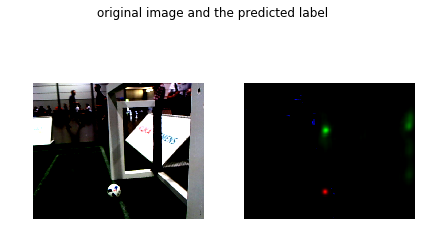

Epoch 57/100
----------
Mean Squared Error Loss: 1218.3152 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 893.8106 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 826.3031 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 767.0435 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1110.6105 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 936.8585 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1041.1783 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 650.3780 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 910.8424 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 587.6186 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 695.0876 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1134.1151 * 1e-03  [2880/2992 (96%)]
Time elapsed: 232m 11s

Average test Loss: 1926.7851 * 1e-03
Average test metrics->RC_ball:92.7, FDR_ball:0.3, RC_goalpost:66.8, FDR_goalpost:24.7, RC_robot:75.4, FDR_robot:12.0 
Time elapsed: 232m 33s



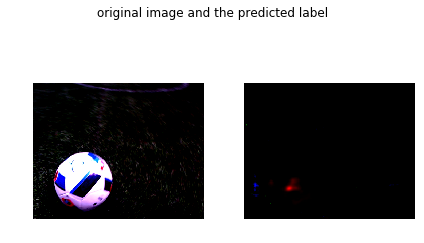

Epoch 58/100
----------
Mean Squared Error Loss: 1293.5169 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 730.7178 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1518.5908 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 817.8604 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 603.9863 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1865.1484 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1154.9258 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1232.7868 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 423.4163 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 658.6647 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 878.8236 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 975.3445 * 1e-03  [2880/2992 (96%)]
Time elapsed: 236m 13s

Average test Loss: 1776.5821 * 1e-03
Average test metrics->RC_ball:93.7, FDR_ball:0.0, RC_goalpost:65.2, FDR_goalpost:17.7, RC_robot:76.9, FDR_robot:10.9 
Time elapsed: 236m 34s



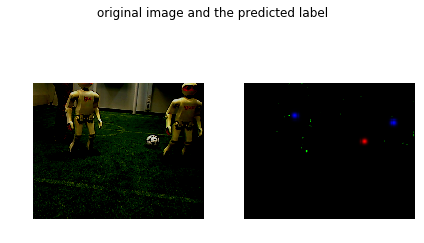

Epoch 59/100
----------
Mean Squared Error Loss: 773.1085 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1549.0450 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1147.5471 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2279.8593 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 993.9131 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 768.2881 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 775.5551 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1252.6003 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1541.6924 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1106.4311 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 294.2777 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1198.7879 * 1e-03  [2880/2992 (96%)]
Time elapsed: 240m 17s

Average test Loss: 2469.2647 * 1e-03
Average test metrics->RC_ball:96.1, FDR_ball:0.3, RC_goalpost:70.8, FDR_goalpost:25.8, RC_robot:77.1, FDR_robot:15.3 
Time elapsed: 240m 38s



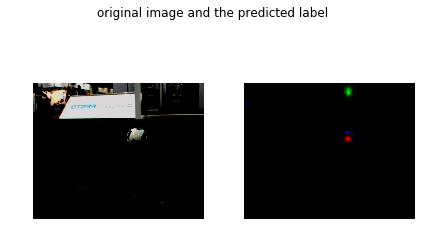

Epoch 60/100
----------
Mean Squared Error Loss: 762.2804 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 917.7079 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 617.4676 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 964.7847 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 3004.0190 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 828.0103 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 557.0868 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 690.4904 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 836.3307 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1639.4235 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1090.4375 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1991.7740 * 1e-03  [2880/2992 (96%)]
Time elapsed: 244m 21s

Average test Loss: 1923.8488 * 1e-03
Average test metrics->RC_ball:95.0, FDR_ball:0.3, RC_goalpost:70.3, FDR_goalpost:21.2, RC_robot:79.9, FDR_robot:9.5 
Time elapsed: 244m 41s



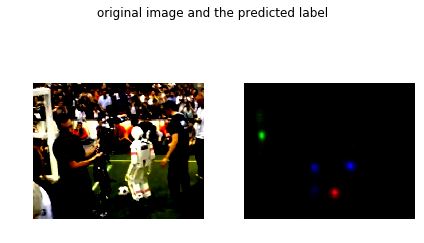

Epoch 61/100
----------
Mean Squared Error Loss: 1268.6007 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1018.8545 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 851.3987 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 826.2884 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 240.8192 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 905.7520 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 921.2902 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1266.5403 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 788.3502 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1537.0415 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 491.6119 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 334.3955 * 1e-03  [2880/2992 (96%)]
Time elapsed: 248m 22s

Average test Loss: 2010.1411 * 1e-03
Average test metrics->RC_ball:92.0, FDR_ball:0.0, RC_goalpost:75.0, FDR_goalpost:33.0, RC_robot:79.1, FDR_robot:9.1 
Time elapsed: 248m 43s



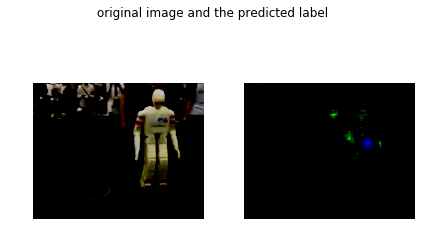

Epoch 62/100
----------
Mean Squared Error Loss: 1441.0168 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 560.8720 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1174.2356 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1521.6027 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 458.5715 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1693.2677 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1406.2369 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1066.3568 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 689.3339 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 946.4091 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 900.8026 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1376.5510 * 1e-03  [2880/2992 (96%)]
Time elapsed: 252m 22s

Average test Loss: 2253.6818 * 1e-03
Average test metrics->RC_ball:94.3, FDR_ball:0.0, RC_goalpost:71.8, FDR_goalpost:35.8, RC_robot:79.3, FDR_robot:10.9 
Time elapsed: 252m 43s



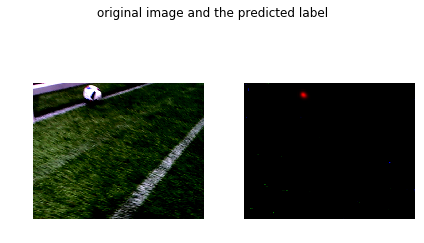

Epoch 63/100
----------
Mean Squared Error Loss: 850.8260 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 807.4220 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 719.8317 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1683.2186 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1076.1635 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 776.9365 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 367.3307 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 937.4575 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2756.5000 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 793.1402 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1925.6264 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 399.1648 * 1e-03  [2880/2992 (96%)]
Time elapsed: 256m 24s

Average test Loss: 1945.9477 * 1e-03
Average test metrics->RC_ball:91.7, FDR_ball:0.3, RC_goalpost:61.5, FDR_goalpost:31.1, RC_robot:83.6, FDR_robot:10.3 
Time elapsed: 256m 44s



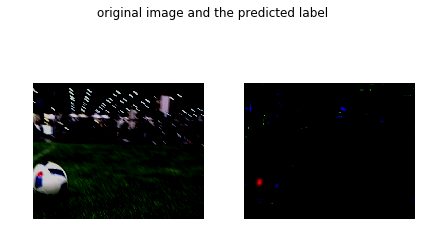

Epoch 64/100
----------
Mean Squared Error Loss: 924.0054 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 379.6162 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1187.6103 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 359.2639 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1024.9180 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 624.7450 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 2067.9677 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2514.3635 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1635.9751 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1038.2594 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 336.8665 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1494.0624 * 1e-03  [2880/2992 (96%)]
Time elapsed: 260m 25s

Average test Loss: 1865.6776 * 1e-03
Average test metrics->RC_ball:98.0, FDR_ball:0.0, RC_goalpost:71.7, FDR_goalpost:22.5, RC_robot:84.2, FDR_robot:9.4 
Time elapsed: 260m 46s



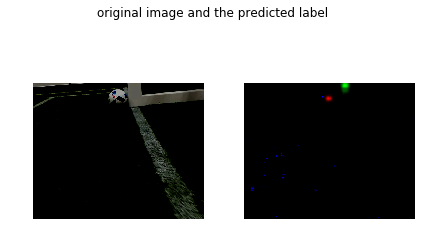

Epoch 65/100
----------
Mean Squared Error Loss: 567.3267 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 925.8537 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 984.7190 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1214.9314 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 421.1228 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 688.3298 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 593.3135 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1555.5154 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 870.3759 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 2045.3129 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 659.6387 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1416.0355 * 1e-03  [2880/2992 (96%)]
Time elapsed: 264m 27s

Average test Loss: 2128.0806 * 1e-03
Average test metrics->RC_ball:95.0, FDR_ball:0.7, RC_goalpost:69.4, FDR_goalpost:30.5, RC_robot:79.1, FDR_robot:17.3 
Time elapsed: 264m 48s



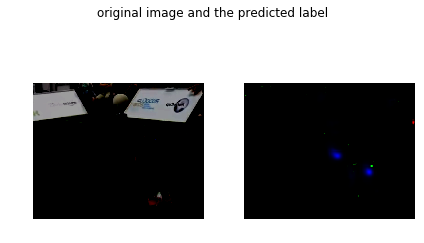

Epoch 66/100
----------
Mean Squared Error Loss: 941.8879 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2169.6434 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 818.4480 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1196.2107 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 384.4536 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 300.1710 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 750.2025 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1640.5892 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1151.2502 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1536.4444 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1800.2955 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1195.4905 * 1e-03  [2880/2992 (96%)]
Time elapsed: 268m 33s

Average test Loss: 1912.6026 * 1e-03
Average test metrics->RC_ball:95.1, FDR_ball:0.0, RC_goalpost:66.3, FDR_goalpost:36.3, RC_robot:78.1, FDR_robot:10.6 
Time elapsed: 268m 55s



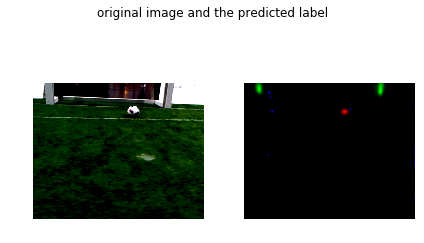

Epoch 67/100
----------
Mean Squared Error Loss: 667.3132 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 631.3709 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1397.4751 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 477.3413 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 583.5308 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1530.6033 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1660.8182 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 604.3925 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1222.2797 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 435.9314 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 681.8997 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 778.5357 * 1e-03  [2880/2992 (96%)]
Time elapsed: 272m 43s

Average test Loss: 2231.5067 * 1e-03
Average test metrics->RC_ball:92.9, FDR_ball:0.0, RC_goalpost:73.6, FDR_goalpost:26.6, RC_robot:85.0, FDR_robot:10.4 
Time elapsed: 273m 5s



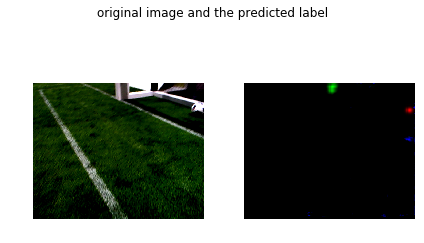

Epoch 68/100
----------
Mean Squared Error Loss: 1272.8360 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 593.1937 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 810.9505 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1063.6829 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 735.1388 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1261.5583 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 593.3640 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1005.5848 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1514.6451 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1323.3759 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1658.6037 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 651.9181 * 1e-03  [2880/2992 (96%)]
Time elapsed: 276m 51s

Average test Loss: 1814.0434 * 1e-03
Average test metrics->RC_ball:96.7, FDR_ball:0.0, RC_goalpost:67.5, FDR_goalpost:24.1, RC_robot:82.7, FDR_robot:10.2 
Time elapsed: 277m 13s



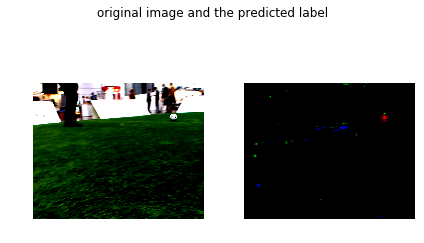

Epoch 69/100
----------
Mean Squared Error Loss: 755.6045 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1300.2491 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 715.7549 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 636.4001 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1230.4099 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1470.8327 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 922.7698 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 930.1324 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 727.5794 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1293.3276 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1274.4949 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 728.4223 * 1e-03  [2880/2992 (96%)]
Time elapsed: 280m 53s

Average test Loss: 1867.6283 * 1e-03
Average test metrics->RC_ball:96.5, FDR_ball:0.0, RC_goalpost:71.4, FDR_goalpost:29.7, RC_robot:78.0, FDR_robot:8.6 
Time elapsed: 281m 14s



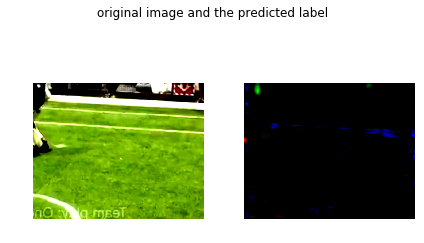

Epoch 70/100
----------
Mean Squared Error Loss: 496.4709 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 977.4789 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1252.7983 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 864.6202 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 716.4277 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1642.9194 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 344.7947 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1047.1909 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1002.0130 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 514.4957 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 816.5093 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1194.0930 * 1e-03  [2880/2992 (96%)]
Time elapsed: 284m 55s

Average test Loss: 2286.3382 * 1e-03
Average test metrics->RC_ball:96.0, FDR_ball:0.0, RC_goalpost:69.9, FDR_goalpost:28.6, RC_robot:84.1, FDR_robot:13.8 
Time elapsed: 285m 16s



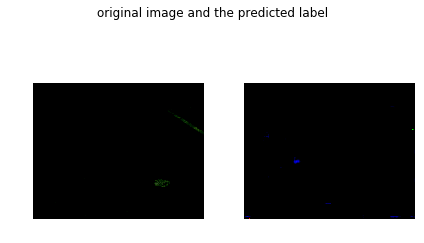

Epoch 71/100
----------
Mean Squared Error Loss: 2806.3877 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 322.4146 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 433.0000 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1661.3977 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 2016.1521 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1113.6187 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1013.7074 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 583.5236 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1157.2113 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1277.5166 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2314.9056 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 382.4607 * 1e-03  [2880/2992 (96%)]
Time elapsed: 288m 57s

Average test Loss: 1885.1535 * 1e-03
Average test metrics->RC_ball:95.9, FDR_ball:0.0, RC_goalpost:66.6, FDR_goalpost:21.8, RC_robot:80.2, FDR_robot:6.9 
Time elapsed: 289m 18s



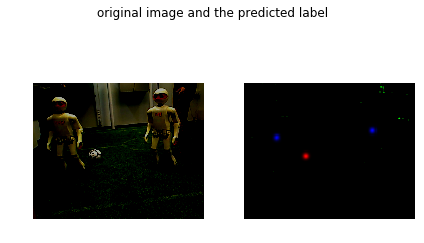

Epoch 72/100
----------
Mean Squared Error Loss: 1953.3304 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 566.4974 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1912.1995 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1042.4033 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 496.5921 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 886.7646 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 618.8061 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 474.7500 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 775.3332 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1132.4841 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1475.6434 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 811.1029 * 1e-03  [2880/2992 (96%)]
Time elapsed: 292m 59s

Average test Loss: 1921.9823 * 1e-03
Average test metrics->RC_ball:94.7, FDR_ball:0.0, RC_goalpost:69.5, FDR_goalpost:28.4, RC_robot:79.9, FDR_robot:14.9 
Time elapsed: 293m 20s



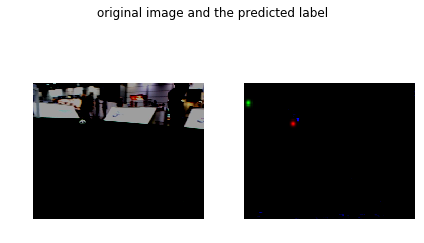

Epoch 73/100
----------
Mean Squared Error Loss: 521.0937 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1008.6685 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1660.3285 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 549.0654 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 359.4926 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 311.6421 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1589.8166 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 486.6171 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 886.7606 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1607.9328 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 688.7773 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 595.2528 * 1e-03  [2880/2992 (96%)]
Time elapsed: 297m 0s

Average test Loss: 2308.3693 * 1e-03
Average test metrics->RC_ball:97.0, FDR_ball:0.0, RC_goalpost:72.7, FDR_goalpost:32.9, RC_robot:83.7, FDR_robot:9.4 
Time elapsed: 297m 21s



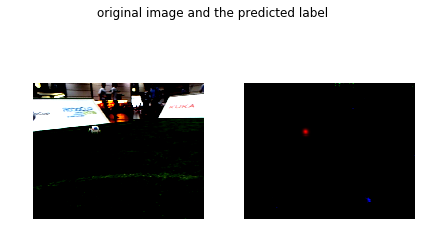

Epoch 74/100
----------
Mean Squared Error Loss: 707.0841 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 431.0655 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1564.9835 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1245.0942 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1177.4786 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 499.3458 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 988.8383 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 574.5732 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1448.0988 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 417.5500 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1697.5138 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1257.5384 * 1e-03  [2880/2992 (96%)]
Time elapsed: 301m 2s

Average test Loss: 1973.7170 * 1e-03
Average test metrics->RC_ball:95.0, FDR_ball:0.0, RC_goalpost:66.9, FDR_goalpost:30.4, RC_robot:84.2, FDR_robot:9.1 
Time elapsed: 301m 23s



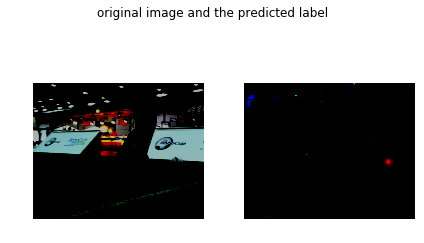

Epoch 75/100
----------
Mean Squared Error Loss: 810.9472 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 338.3480 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1197.3976 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 669.9795 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 886.6537 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 667.6273 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1259.7789 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 828.0245 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 967.5719 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1823.7785 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 665.4842 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1129.1225 * 1e-03  [2880/2992 (96%)]
Time elapsed: 305m 3s

Average test Loss: 2178.3208 * 1e-03
Average test metrics->RC_ball:95.0, FDR_ball:0.3, RC_goalpost:69.5, FDR_goalpost:28.2, RC_robot:77.0, FDR_robot:8.5 
Time elapsed: 305m 24s



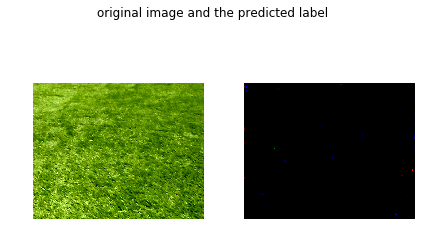

Epoch 76/100
----------
Mean Squared Error Loss: 570.4137 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 886.8731 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1196.5135 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 995.0993 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1855.3374 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 879.4493 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 587.8060 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 942.3725 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1061.4778 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1036.5644 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 953.2543 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1078.1263 * 1e-03  [2880/2992 (96%)]
Time elapsed: 309m 4s

Average test Loss: 2285.4572 * 1e-03
Average test metrics->RC_ball:93.8, FDR_ball:0.0, RC_goalpost:68.8, FDR_goalpost:22.2, RC_robot:85.7, FDR_robot:8.5 
Time elapsed: 309m 25s



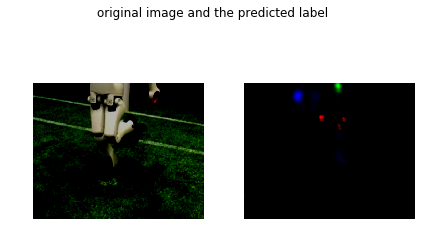

Epoch 77/100
----------
Mean Squared Error Loss: 889.4787 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 849.7021 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 747.5712 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 608.5333 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 728.7287 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 633.4098 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1135.1970 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1221.0460 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 956.2113 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 452.1810 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 893.9502 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1013.0391 * 1e-03  [2880/2992 (96%)]
Time elapsed: 313m 5s

Average test Loss: 1785.1593 * 1e-03
Average test metrics->RC_ball:96.2, FDR_ball:0.0, RC_goalpost:71.8, FDR_goalpost:22.8, RC_robot:78.5, FDR_robot:7.7 
Time elapsed: 313m 26s



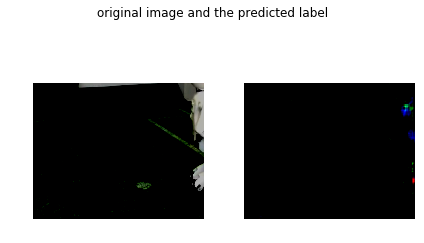

Epoch 78/100
----------
Mean Squared Error Loss: 732.9863 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1505.2305 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 569.9762 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1398.0253 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1473.4689 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 816.2165 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 606.9890 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1161.2594 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 583.7494 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 328.0458 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 600.7836 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 621.9975 * 1e-03  [2880/2992 (96%)]
Time elapsed: 317m 7s

Average test Loss: 1665.6601 * 1e-03
Average test metrics->RC_ball:93.4, FDR_ball:0.0, RC_goalpost:74.3, FDR_goalpost:25.5, RC_robot:77.6, FDR_robot:9.8 
Time elapsed: 317m 27s



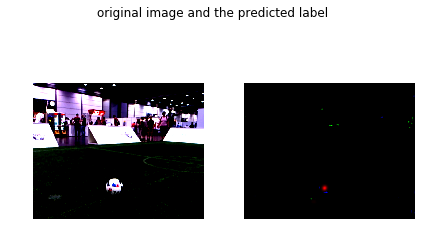

Epoch 79/100
----------
Mean Squared Error Loss: 1103.2120 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1115.5133 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1766.0109 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 399.0115 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1520.3322 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1011.5917 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1128.9207 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 427.2717 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 811.0658 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1237.0522 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 2751.0655 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 697.3623 * 1e-03  [2880/2992 (96%)]
Time elapsed: 321m 7s

Average test Loss: 2112.3421 * 1e-03
Average test metrics->RC_ball:95.0, FDR_ball:0.3, RC_goalpost:70.4, FDR_goalpost:18.2, RC_robot:84.5, FDR_robot:6.0 
Time elapsed: 321m 28s



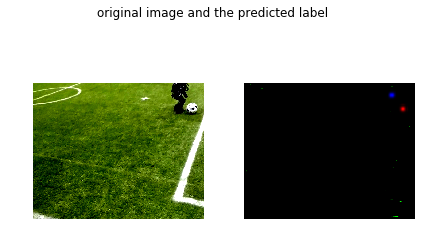

Epoch 80/100
----------
Mean Squared Error Loss: 1530.3605 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 858.4422 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1109.3317 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 802.8441 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 855.3453 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 483.0277 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 751.6633 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 883.4675 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 3156.7900 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1014.1598 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 355.6609 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1171.7738 * 1e-03  [2880/2992 (96%)]
Time elapsed: 325m 11s

Average test Loss: 1953.6351 * 1e-03
Average test metrics->RC_ball:96.2, FDR_ball:0.6, RC_goalpost:79.9, FDR_goalpost:22.2, RC_robot:80.1, FDR_robot:11.7 
Time elapsed: 325m 32s



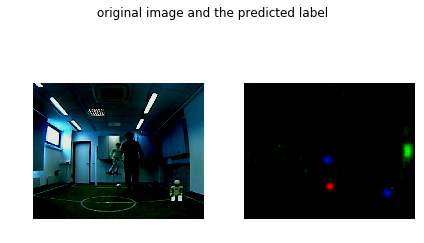

Epoch 81/100
----------
Mean Squared Error Loss: 1689.3829 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1346.3643 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 819.6542 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 740.5908 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1533.7303 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 878.6231 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 323.7664 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1440.1851 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 603.8502 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1000.2103 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 479.0730 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 893.9239 * 1e-03  [2880/2992 (96%)]
Time elapsed: 329m 19s

Average test Loss: 2150.0282 * 1e-03
Average test metrics->RC_ball:98.3, FDR_ball:0.3, RC_goalpost:73.9, FDR_goalpost:29.4, RC_robot:79.1, FDR_robot:8.6 
Time elapsed: 329m 40s



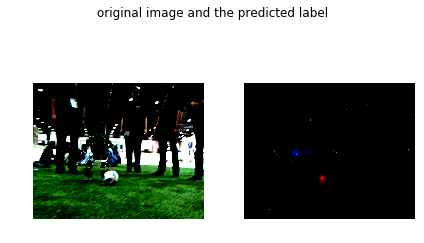

Epoch 82/100
----------
Mean Squared Error Loss: 845.2972 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 861.8029 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 737.1597 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 458.2429 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 2818.8703 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1063.2986 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1118.1892 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1930.6748 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 693.5929 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1593.5662 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1807.1507 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 920.7891 * 1e-03  [2880/2992 (96%)]
Time elapsed: 333m 22s

Average test Loss: 2140.0494 * 1e-03
Average test metrics->RC_ball:95.8, FDR_ball:0.5, RC_goalpost:72.5, FDR_goalpost:24.3, RC_robot:84.6, FDR_robot:7.7 
Time elapsed: 333m 43s



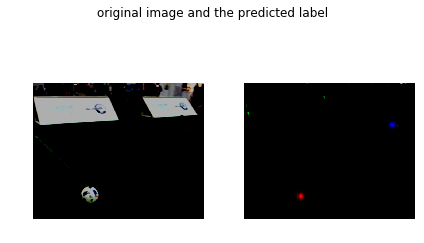

Epoch 83/100
----------
Mean Squared Error Loss: 778.7443 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 749.6015 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1150.8107 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 965.6041 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1602.4292 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1993.7061 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 788.5099 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 827.5941 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 268.4135 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 594.5587 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 614.2511 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 934.6588 * 1e-03  [2880/2992 (96%)]
Time elapsed: 337m 26s

Average test Loss: 2232.1610 * 1e-03
Average test metrics->RC_ball:96.4, FDR_ball:0.8, RC_goalpost:73.9, FDR_goalpost:22.0, RC_robot:82.4, FDR_robot:8.8 
Time elapsed: 337m 47s



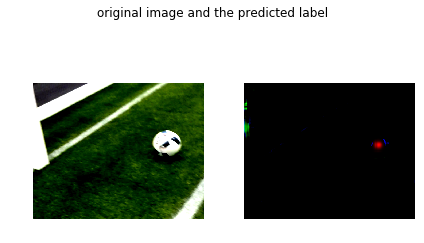

Epoch 84/100
----------
Mean Squared Error Loss: 1661.3833 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1134.1517 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 693.7506 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 676.5937 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1157.3156 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1403.6198 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 924.8660 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 2015.0163 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 2864.6760 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 518.3942 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 738.4862 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 362.8204 * 1e-03  [2880/2992 (96%)]
Time elapsed: 341m 32s

Average test Loss: 2367.2983 * 1e-03
Average test metrics->RC_ball:95.5, FDR_ball:0.0, RC_goalpost:74.5, FDR_goalpost:25.1, RC_robot:80.6, FDR_robot:9.0 
Time elapsed: 341m 53s



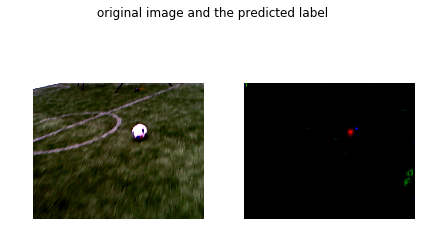

Epoch 85/100
----------
Mean Squared Error Loss: 1506.8716 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 750.4502 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1219.6239 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 673.9980 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 439.0821 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1216.7948 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1343.4635 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1073.2610 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1341.8142 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 746.0660 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 810.7442 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 944.8962 * 1e-03  [2880/2992 (96%)]
Time elapsed: 345m 37s

Average test Loss: 2025.1471 * 1e-03
Average test metrics->RC_ball:95.3, FDR_ball:0.6, RC_goalpost:71.8, FDR_goalpost:23.4, RC_robot:81.5, FDR_robot:11.5 
Time elapsed: 345m 59s



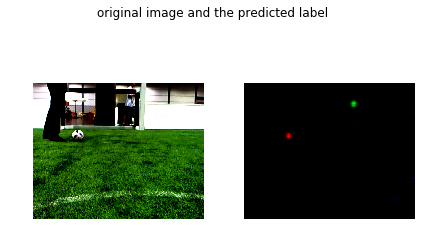

Epoch 86/100
----------
Mean Squared Error Loss: 709.2754 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 546.8712 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 475.4018 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1914.1116 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 988.7978 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 865.3070 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1306.5872 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 867.1010 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 665.5804 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 401.9262 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 410.4620 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 584.3276 * 1e-03  [2880/2992 (96%)]
Time elapsed: 349m 47s

Average test Loss: 2435.5096 * 1e-03
Average test metrics->RC_ball:92.1, FDR_ball:0.0, RC_goalpost:68.8, FDR_goalpost:33.3, RC_robot:85.1, FDR_robot:13.4 
Time elapsed: 350m 8s



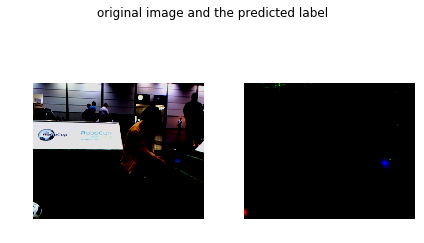

Epoch 87/100
----------
Mean Squared Error Loss: 1830.6384 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2071.6085 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 631.0320 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1710.9897 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 686.3750 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1589.0777 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 682.2992 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 583.6229 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1281.5624 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1154.2547 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1108.0191 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 660.2930 * 1e-03  [2880/2992 (96%)]
Time elapsed: 353m 58s

Average test Loss: 2107.4361 * 1e-03
Average test metrics->RC_ball:94.0, FDR_ball:0.6, RC_goalpost:71.9, FDR_goalpost:15.8, RC_robot:86.0, FDR_robot:6.1 
Time elapsed: 354m 19s



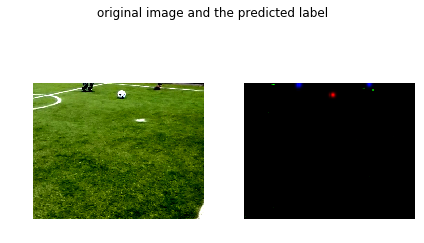

Epoch 88/100
----------
Mean Squared Error Loss: 1378.7302 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 852.3028 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 665.1078 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1177.7878 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 761.0530 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 852.8442 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 782.0229 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 526.0037 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 855.7875 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 689.4218 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 936.8010 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 559.2716 * 1e-03  [2880/2992 (96%)]
Time elapsed: 358m 5s

Average test Loss: 2081.3196 * 1e-03
Average test metrics->RC_ball:93.5, FDR_ball:0.3, RC_goalpost:74.6, FDR_goalpost:15.6, RC_robot:84.7, FDR_robot:4.7 
Time elapsed: 358m 28s



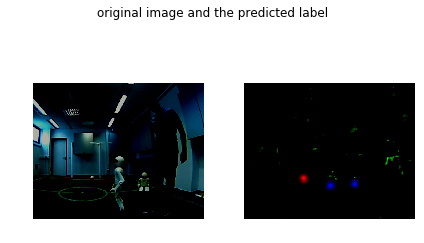

Epoch 89/100
----------
Mean Squared Error Loss: 2150.0902 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 926.0239 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 968.8884 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 709.1141 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1420.3783 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 353.7657 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1164.0117 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 740.9331 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1810.5557 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 920.1123 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 588.8949 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1315.0553 * 1e-03  [2880/2992 (96%)]
Time elapsed: 362m 14s

Average test Loss: 2355.4658 * 1e-03
Average test metrics->RC_ball:97.7, FDR_ball:0.6, RC_goalpost:73.8, FDR_goalpost:25.9, RC_robot:78.6, FDR_robot:8.5 
Time elapsed: 362m 35s



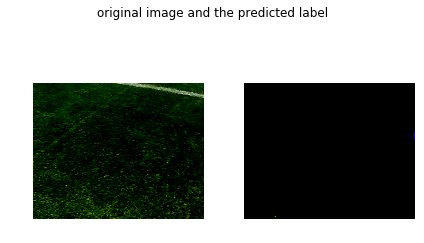

Epoch 90/100
----------
Mean Squared Error Loss: 683.9106 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 563.2889 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 493.5955 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1279.5906 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 593.5937 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1146.3304 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1087.1339 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 906.9031 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 508.5680 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1219.8390 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 784.8828 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1374.4923 * 1e-03  [2880/2992 (96%)]
Time elapsed: 366m 21s

Average test Loss: 2065.8156 * 1e-03
Average test metrics->RC_ball:94.4, FDR_ball:0.3, RC_goalpost:76.4, FDR_goalpost:27.5, RC_robot:80.0, FDR_robot:9.3 
Time elapsed: 366m 42s



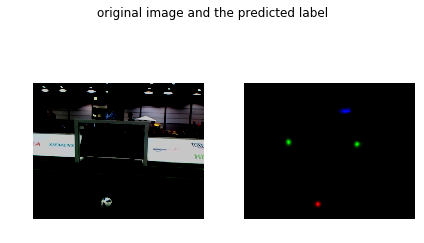

Epoch 91/100
----------
Mean Squared Error Loss: 585.8681 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 549.6709 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 810.6962 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 2138.4761 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1314.7420 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1404.5823 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1316.7307 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 807.6314 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 989.1450 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1140.0878 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 819.6269 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 529.0009 * 1e-03  [2880/2992 (96%)]
Time elapsed: 370m 23s

Average test Loss: 2055.6169 * 1e-03
Average test metrics->RC_ball:95.5, FDR_ball:0.3, RC_goalpost:74.8, FDR_goalpost:22.4, RC_robot:81.8, FDR_robot:20.6 
Time elapsed: 370m 43s



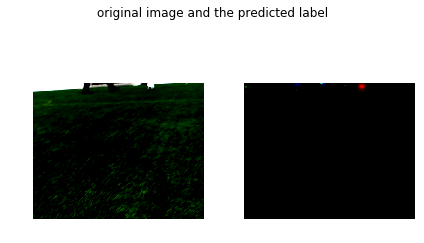

Epoch 92/100
----------
Mean Squared Error Loss: 755.4521 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 508.5744 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 769.1051 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 576.3737 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 788.7045 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 767.0933 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1845.3268 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1037.5465 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 941.0115 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 522.8459 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1002.7919 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 663.9741 * 1e-03  [2880/2992 (96%)]
Time elapsed: 374m 24s

Average test Loss: 2620.8161 * 1e-03
Average test metrics->RC_ball:95.4, FDR_ball:0.0, RC_goalpost:72.5, FDR_goalpost:27.3, RC_robot:81.2, FDR_robot:12.4 
Time elapsed: 374m 45s



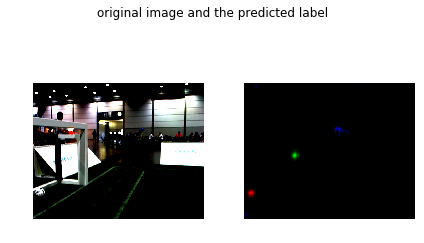

Epoch 93/100
----------
Mean Squared Error Loss: 782.4299 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 251.2406 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 854.0134 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1294.2783 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 523.6871 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1351.4857 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 892.5012 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 457.1137 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1529.3095 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1618.8018 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 897.1115 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 716.9843 * 1e-03  [2880/2992 (96%)]
Time elapsed: 378m 30s

Average test Loss: 1915.6561 * 1e-03
Average test metrics->RC_ball:96.3, FDR_ball:0.3, RC_goalpost:75.5, FDR_goalpost:23.1, RC_robot:81.1, FDR_robot:8.9 
Time elapsed: 378m 51s



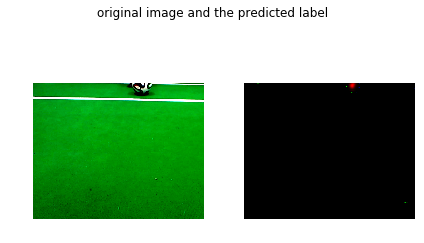

Epoch 94/100
----------
Mean Squared Error Loss: 720.7487 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 627.8313 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 774.9037 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1415.3926 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1002.1164 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1211.2857 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 689.4837 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1212.6189 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1275.9479 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 360.3500 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1090.1694 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 373.1795 * 1e-03  [2880/2992 (96%)]
Time elapsed: 382m 33s

Average test Loss: 2123.0765 * 1e-03
Average test metrics->RC_ball:94.6, FDR_ball:0.8, RC_goalpost:65.4, FDR_goalpost:26.6, RC_robot:79.8, FDR_robot:13.7 
Time elapsed: 382m 54s



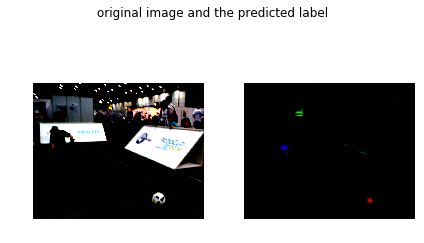

Epoch 95/100
----------
Mean Squared Error Loss: 1222.8624 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 892.9180 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1083.7328 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 625.9939 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 567.5934 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 773.5454 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1217.2940 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 815.4877 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 923.5024 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 858.4443 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1145.6789 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 612.7977 * 1e-03  [2880/2992 (96%)]
Time elapsed: 386m 35s

Average test Loss: 2109.2301 * 1e-03
Average test metrics->RC_ball:93.6, FDR_ball:0.3, RC_goalpost:74.0, FDR_goalpost:23.2, RC_robot:82.3, FDR_robot:5.4 
Time elapsed: 386m 56s



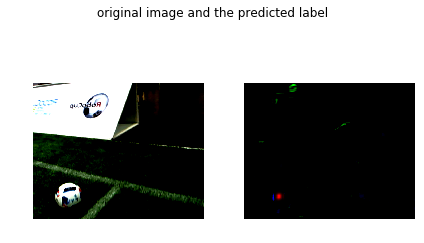

Epoch 96/100
----------
Mean Squared Error Loss: 654.0585 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 619.8829 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 2038.0633 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 1974.9233 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 288.5670 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1438.1300 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1030.2976 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1587.8903 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1547.7678 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1151.9353 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1696.8108 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 279.0627 * 1e-03  [2880/2992 (96%)]
Time elapsed: 390m 40s

Average test Loss: 2356.1672 * 1e-03
Average test metrics->RC_ball:94.8, FDR_ball:0.5, RC_goalpost:70.0, FDR_goalpost:26.9, RC_robot:86.0, FDR_robot:6.5 
Time elapsed: 391m 2s



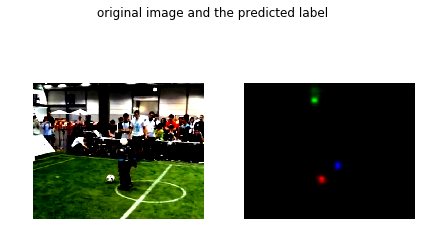

Epoch 97/100
----------
Mean Squared Error Loss: 854.3816 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1015.0495 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 700.2980 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 973.9656 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 537.1397 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 600.6421 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 509.3161 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 943.0653 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 632.6994 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 667.7210 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 535.5681 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1305.4862 * 1e-03  [2880/2992 (96%)]
Time elapsed: 394m 46s

Average test Loss: 2070.7682 * 1e-03
Average test metrics->RC_ball:93.7, FDR_ball:0.0, RC_goalpost:71.5, FDR_goalpost:16.9, RC_robot:78.6, FDR_robot:9.1 
Time elapsed: 395m 8s



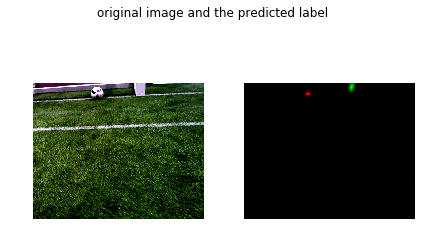

Epoch 98/100
----------
Mean Squared Error Loss: 771.0643 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 581.0855 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 420.1343 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 561.1472 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 862.3301 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1005.3803 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 1336.6553 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 603.7425 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 744.3348 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1393.2298 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 1199.9763 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 560.5711 * 1e-03  [2880/2992 (96%)]
Time elapsed: 398m 54s

Average test Loss: 2114.2482 * 1e-03
Average test metrics->RC_ball:96.5, FDR_ball:0.0, RC_goalpost:77.5, FDR_goalpost:19.4, RC_robot:80.5, FDR_robot:8.7 
Time elapsed: 399m 16s



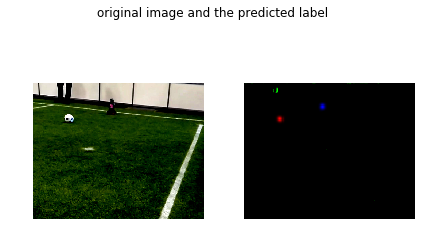

Epoch 99/100
----------
Mean Squared Error Loss: 709.4445 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 2042.1779 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 476.1191 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 532.4410 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 675.5078 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 473.6927 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 894.1911 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 473.6539 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 1306.1477 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1023.2795 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 297.7218 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1580.3903 * 1e-03  [2880/2992 (96%)]
Time elapsed: 403m 4s

Average test Loss: 2271.7753 * 1e-03
Average test metrics->RC_ball:95.5, FDR_ball:0.0, RC_goalpost:79.4, FDR_goalpost:29.7, RC_robot:82.6, FDR_robot:10.0 
Time elapsed: 403m 25s



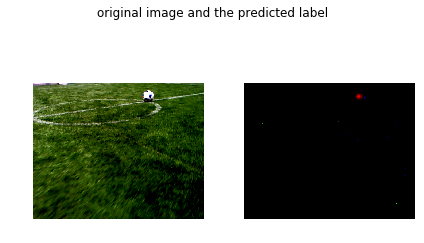

Epoch 100/100
----------
Mean Squared Error Loss: 1950.6098 * 1e-03  [240/2992 (8%)]
Mean Squared Error Loss: 1025.4849 * 1e-03  [480/2992 (16%)]
Mean Squared Error Loss: 1065.7578 * 1e-03  [720/2992 (24%)]
Mean Squared Error Loss: 712.2999 * 1e-03  [960/2992 (32%)]
Mean Squared Error Loss: 1110.4420 * 1e-03  [1200/2992 (40%)]
Mean Squared Error Loss: 1343.1251 * 1e-03  [1440/2992 (48%)]
Mean Squared Error Loss: 436.9569 * 1e-03  [1680/2992 (56%)]
Mean Squared Error Loss: 1397.8970 * 1e-03  [1920/2992 (64%)]
Mean Squared Error Loss: 835.4120 * 1e-03  [2160/2992 (72%)]
Mean Squared Error Loss: 1051.1538 * 1e-03  [2400/2992 (80%)]
Mean Squared Error Loss: 680.1524 * 1e-03  [2640/2992 (88%)]
Mean Squared Error Loss: 1009.5370 * 1e-03  [2880/2992 (96%)]
Time elapsed: 407m 12s

Average test Loss: 2152.7623 * 1e-03
Average test metrics->RC_ball:96.2, FDR_ball:0.0, RC_goalpost:66.7, FDR_goalpost:21.0, RC_robot:82.4, FDR_robot:6.5 
Time elapsed: 407m 33s



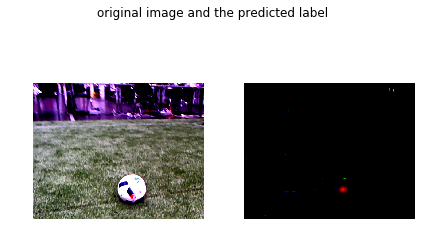

Total number of images with at least 1 object present: 2851.71
Training complete in 407m 34s
size of training set:2992 ;size of test set:336


In [37]:
loss_vec_train=[] # average training loss of each epoch
loss_vec_test=[]

model1,result_metrics,__=train(100,True,True,new_t)

output size torch.Size([3, 512, 640])
[ 91.91191101  73.03417206   0.47283933]


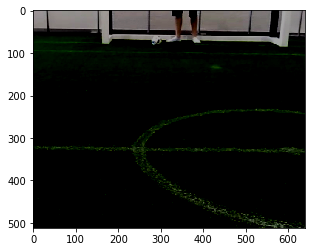

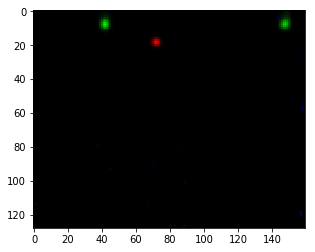

In [30]:
"""Visualize model output"""
for inputs, labels in train_loader:
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())
    print("output size",inputs[0].shape)
    outputs = model1(inputs)  # (3,128,160)
    input1=inputs.data[0].cpu().numpy().transpose((1,2,0))+0.2
    output1=outputs.data[0].cpu().numpy().transpose((1,2,0))  
    
    print(np.amax(output1,axis=(0,1)))
    
    output1=output1/(output1.max(axis=(0,1)) + 1e-7)
    input1=np.clip(input1, 0, 1)
    output1=np.clip(output1, 0, 1)
    plt.figure()
    plt.imshow(input1)
    plt.figure()
    plt.imshow(output1)
    break

### Plot RC and FDR in two plots

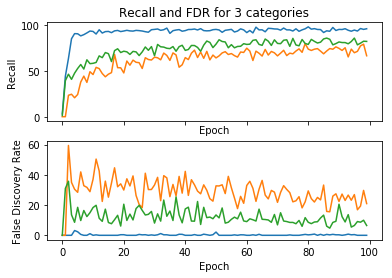

In [39]:
def plot_metrics(metrics):
    # plot learning curve
    fig, axarr = plt.subplots(2, sharex=True)

    x_axis = [i for i in range(len(metrics))]
    axarr[0].set_xlabel('Epoch')
    axarr[0].set_ylabel('Recall')
    axarr[1].set_xlabel('Epoch')
    axarr[1].set_ylabel('False Discovery Rate')
    for j in range(3):
        axarr[0].plot(x_axis, metrics[:,j*2])
        axarr[1].plot(x_axis, metrics[:,j*2+1])
    title_line = "Recall and FDR for 3 categories"
    axarr[0].set_title(title_line)
    save_path = "Performance.png"
    fig.savefig(save_path)
    plt.show()
    plt.close(fig)


result_metrics = np.delete(result_metrics, (0), axis=0)  # remove the 1st row with zeros

plot_metrics(result_metrics)

### Print out images for comparisons of input and output

In [32]:
def get_images(n):
    """save model output"""
    i=0
    for inputs, labels in train_loader:
        
        inputs = Variable(inputs.cuda())
        labels1 = labels[i].numpy().transpose((1,2,0))
        labels1=labels1/(labels1.max(axis=(0,1)) + 1e-7)
        outputs = model1(inputs)  # (3,128,160)
        input1=inputs.data[i].cpu().numpy().transpose((1,2,0))+0.2
        output1=outputs.data[i].cpu().numpy().transpose((1,2,0))
        
        peaks=peak_detector(outputs.data[i].cpu(),threshold=0.7,threshold_vec=thresholding_vector)
        processed=get_processed_label(peaks,sigma=1.5)
        i+=1
        # Visualize label along with the image       
        output1=output1/(output1.max(axis=(0,1)) + 1e-7)
        input1=np.clip(input1, 0, 1)
        output1=np.clip(output1, 0, 1) 
        fig1, axes1 = plt.subplots(nrows=2, ncols=2)
        fig1.suptitle("Comparison of model input and output")
        axes1[0,0].imshow(input1)
        axes1[0,0].axis("off")
        axes1[0,1].imshow(labels1)
        axes1[0,1].axis("off")
        axes1[1,0].imshow(output1)
        axes1[1,0].axis("off")
        axes1[1,1].imshow(processed)
        axes1[1,1].axis("off")
        fig1.tight_layout()
        fig1.subplots_adjust(top=0.92)
        save_path = "Comparison_of_model_input_and_output"+str(i)+".png"
        fig1.savefig(save_path)
        plt.show()
        if i==(n):
            break

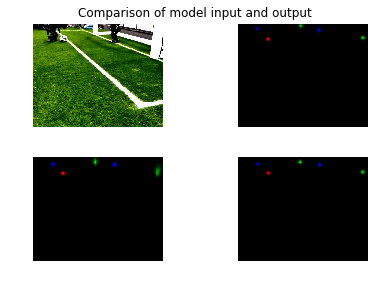

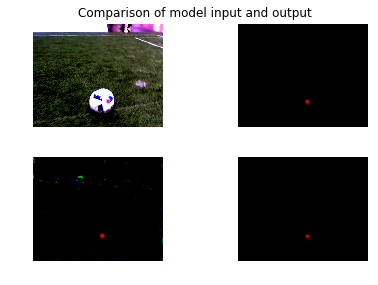

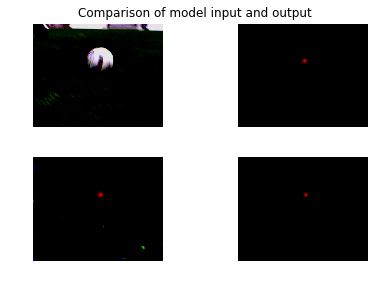

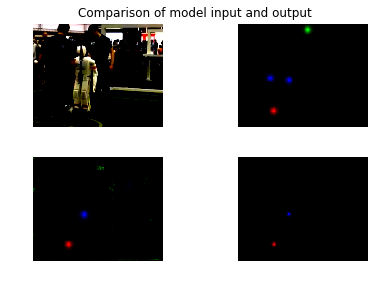

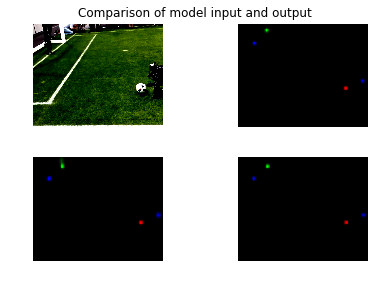

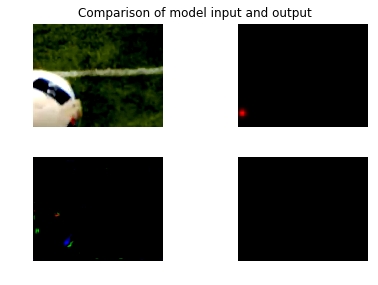

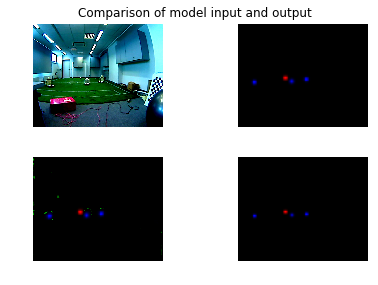

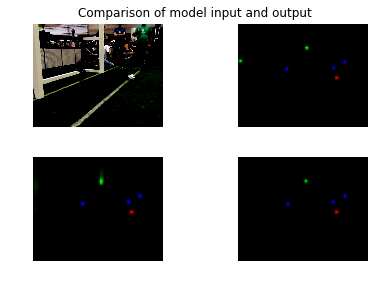

In [33]:
get_images(8)

#Top: original image (left), true label(middle); bottom: raw output(left)/ processed output(right)